In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
  cd '/content/drive/MyDrive/Score-BasedDiffusionModels/'

/content/drive/MyDrive/Score-BasedDiffusionModels


In [7]:
import torch

def get_device():
    """
    Returns the available device ('cuda', 'mps', or 'cpu').
    """
    if torch.cuda.is_available():
        return 'cuda'
    elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
        return 'mps'
    else:
        return 'cpu'

device = get_device()
print('Device in use:', device)

Device in use: cuda


In [ ]:
device = 'cpu'

# Score-based Diffussion Models

## Libraries

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import functools
# For the neural networks
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
# For working with images
from PIL import Image
import io
from IPython.display import Image as IPImage, display

## MLE vs SME


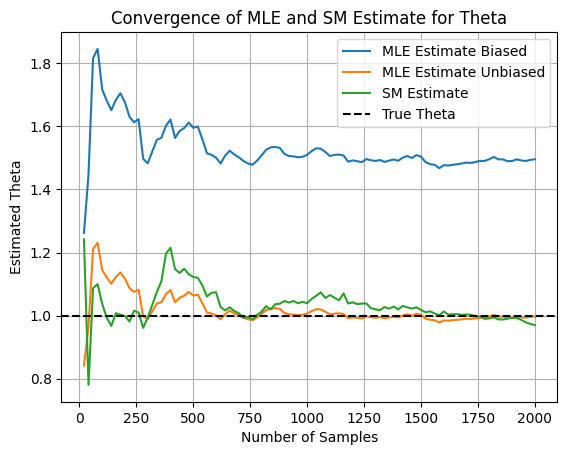

True Theta: 1.0
Final MLE Estimate: 1.4957967885931223
Final MLE Estimate: 0.9971978590620816
Final SME Estimate: 0.9698339212286754


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# True value of theta
theta_true = 1.0

# Define the PDF p(x; theta)
def p(x, theta):
    return (2 * theta**(3/2) / np.sqrt(np.pi)) * x**2 * np.exp(-theta * x**2)

# MLE Estimator for theta
def mle_estimate(samples):
    return (3 * len(samples)) / (2 * np.sum(samples**2))

def mle_unbiased(samples):
    return (2/3) * (3 * len(samples)) / (2 * np.sum(samples**2))

# SME Estimator for theta
def sme_estimate(samples):
    return (len(samples)) / (np.sum(samples**2) + 2 * np.sum(samples))

# Simulate data from the true distribution p(x; theta_true)
# np.random.seed(42)
n_samples = 20000
samples = np.random.normal(0, 1, n_samples)  # Normal distribution for simplicity

# Calculate MLE and SME for different sample sizes
theta_values_mle1 = []
theta_values_mle2 = []
theta_values_sme = []

for i in range(1, 101):
    sample_subset = samples[:i*20]  # increasing number of samples
    theta_mle1 = mle_estimate(sample_subset)
    theta_mle2 = mle_unbiased(sample_subset)
    theta_sme = sme_estimate(sample_subset)
    theta_values_mle1.append(theta_mle1)
    theta_values_mle2.append(theta_mle2)
    theta_values_sme.append(theta_sme)

# Plot the convergence of theta_estimate
plt.plot(np.arange(1, 101) * 20, theta_values_mle1, label='MLE Estimate Biased')
plt.plot(np.arange(1, 101) * 20, theta_values_mle2, label='MLE Estimate Unbiased')
plt.plot(np.arange(1, 101) * 20, theta_values_sme, label='SM Estimate')
plt.axhline(theta_true, color='black', linestyle='--', label='True Theta')
plt.xlabel('Number of Samples')
plt.ylabel('Estimated Theta')
plt.legend()
plt.title('Convergence of MLE and SM Estimate for Theta')
plt.grid(True)
plt.show()

# Print the final estimate
print(f"True Theta: {theta_true}")
print(f"Final MLE Estimate: {theta_values_mle1[-1]}")
print(f"Final MLE Estimate: {theta_values_mle2[-1]}")
print(f"Final SME Estimate: {theta_values_sme[-1]}")


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def mixture_model(x, y, mu1, mu2, sigma1=0.5, sigma2=0.25, alpha=0.5):
    # Compute the gaussians
    g1 = np.exp(-((x - mu1[0])**2 + (y - mu1[1])**2) / (2 * sigma1**2))
    g2 = alpha * np.exp(-((x - mu2[0])**2 + (y - mu2[1])**2) / (2 * sigma2**2))

    return g1, g2

def prob_density(x, y, mu1, mu2, sigma1=0.5, sigma2=0.25, alpha=0.5):
    # Get the gaussians
    g1, g2 = mixture_model(x, y, mu1, mu2, sigma1, sigma2, alpha)

    return g1 + g2

def log_prob_density(x, y, mu1, mu2, sigma1=0.5, sigma2=0.25, alpha=0.5):
    # Get the probability density
    p = prob_density(x, y, mu1, mu2, sigma1, sigma2, alpha)

    return np.log(p)

def first_der(x, y, mu1, mu2, sigma1=0.5, sigma2=0.25, alpha=0.5):
    # Get the gaussians
    g1, g2 = mixture_model(x, y, mu1, mu2, sigma1, sigma2, alpha)

    # Compute the first derivatives
    dg1_dx = -((x-mu1[0])*sigma1**2)*g1
    dg1_dy = -((y-mu1[1])*sigma1**2)*g1
    dg2_dx = -((x-mu2[0])*sigma2**2)*g2
    dg2_dy = -((y-mu2[1])*sigma2**2)*g2

    return dg1_dx, dg2_dx, dg1_dy, dg2_dy

def second_der(x, y, mu1, mu2, sigma1=0.5, sigma2=0.25, alpha=0.5):
    # Get the gaussians
    g1, g2 = mixture_model(x, y, mu1, mu2, sigma1, sigma2, alpha)

    # Compute the second derivatives
    d2g1_dx2 = ((x - mu1[0])**2 / sigma1**4 - 1 / sigma1**2) * g1
    d2g1_dy2 = ((y - mu1[1])**2 / sigma1**4 - 1 / sigma1**2) * g1
    d2g2_dx2 = ((x - mu2[0])**2 / sigma2**4 - 1 / sigma2**2) * g2
    d2g2_dy2 = ((y - mu2[1])**2 / sigma2**4 - 1 / sigma2**2) * g2


    return d2g1_dx2, d2g2_dx2, d2g1_dy2, d2g2_dy2

def grad_p(x, y, mu1, mu2, sigma1=0.5, sigma2=0.25, alpha=0.5):
      # Get the first derivatives
      dg1_dx, dg2_dx, dg1_dy, dg2_dy = first_der(x, y, mu1, mu2, sigma1, sigma2, alpha)

      # Compute the gradients of p
      grad_x = dg1_dx + dg2_dx
      grad_y = dg1_dy + dg2_dy

      return grad_x, grad_y

def grad_log_p(x, y, mu1, mu2, sigma1=0.5, sigma2=0.25, alpha=0.5):
      # Get the probability density
      p = prob_density(x, y, mu1, mu2, sigma1, sigma2, alpha)

      # Get the first derivatives
      dg1_dx, dg2_dx, dg1_dy, dg2_dy = first_der(x, y, mu1, mu2, sigma1, sigma2, alpha)

      # Compute the gradients of log p
      grad_x = dg1_dx/p + dg2_dx/p
      grad_y = dg1_dy/p + dg2_dy/p

      return grad_x, grad_y

def laplacian_log_p(x, y, mu1, mu2, sigma1=0.5, sigma2=0.25, alpha=0.5):
    # Get the probability density
    p = prob_density(x, y, mu1, mu2, sigma1, sigma2, alpha)

    # Get the first derivatives of p
    dg1_dx, dg2_dx, dg1_dy, dg2_dy = first_der(x, y, mu1, mu2, sigma1, sigma2, alpha)

    # Get the second derivatives of p
    d2g1_dx2, d2g2_dx2, d2g1_dy2, d2g2_dy2 = second_der(x, y, mu1, mu2, sigma1, sigma2, alpha)

    # Compute the derivatives of log p
    dlogp_dx = (dg1_dx + dg2_dx) / p
    dlogp_dy = (dg1_dy + dg2_dy) / p

    # Compute the Laplacian
    laplacian = ((d2g1_dx2 + d2g2_dx2 + d2g1_dy2 + d2g2_dy2) / p) - (dlogp_dx**2 + dlogp_dy**2)

    return laplacian

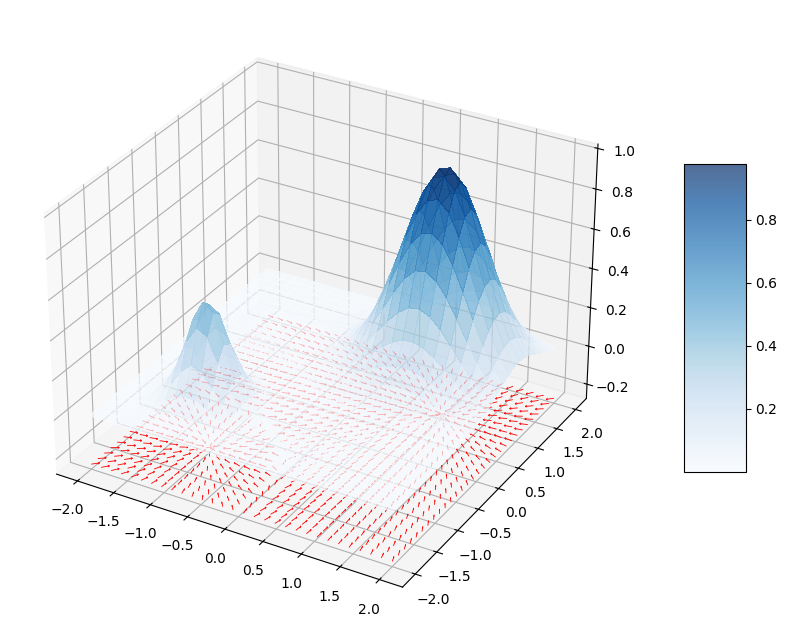

In [ ]:
mu1 = np.array([1.0, 1.0])
mu2 = np.array([-1.0, -1.0])

x = np.linspace(-2, 2, 30)
y = np.linspace(-2, 2, 30)
X, Y = np.meshgrid(x, y)

Z = prob_density(X,Y,mu1,mu2)

fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111, projection='3d')

surface = ax.plot_surface(X, Y, Z,  cmap='Blues', edgecolor='none', antialiased=False, alpha=.7)

fig.colorbar(surface, shrink=0.5, aspect=5)

U0,V0 = grad_p(X,Y,mu1,mu2)

Z0 = np.zeros_like(X) - 0.25

ax.quiver(X, Y , Z0, U0, V0, np.zeros_like(Z0), color='r', arrow_length_ratio=0.2, length=.1, normalize=True, linewidth=.6)

plt.show()

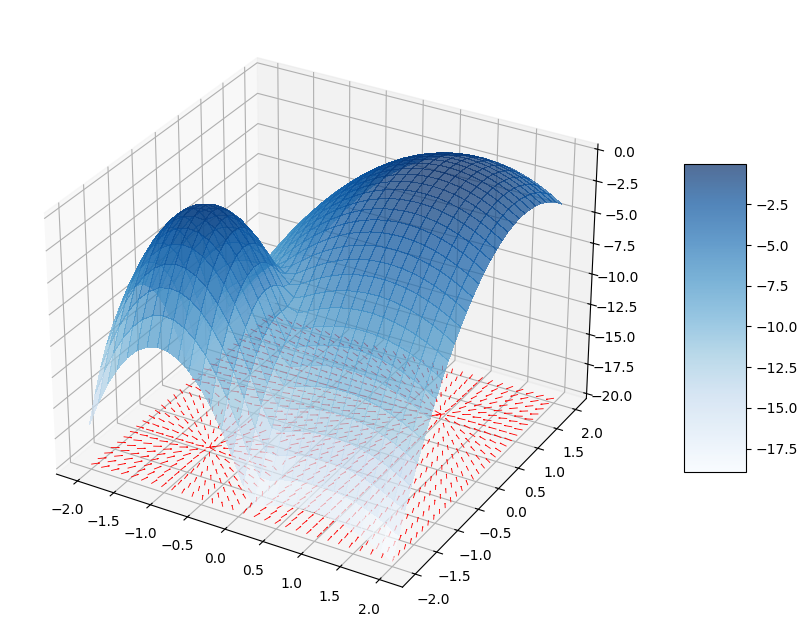

In [ ]:
mu1 = np.array([1.0, 1.0])
mu2 = np.array([-1.0, -1.0])

x = np.linspace(-2, 2, 30)
y = np.linspace(-2, 2, 30)
X, Y = np.meshgrid(x, y)

Z = log_prob_density(X,Y,mu1,mu2)

fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111, projection='3d')

surface = ax.plot_surface(X, Y, Z,  cmap='Blues', edgecolor='none', antialiased=False, alpha=.7)

fig.colorbar(surface, shrink=0.5, aspect=5)

U0,V0 = grad_log_p(X,Y,mu1,mu2)

Z0 = np.zeros_like(X) - 20

ax.quiver(X, Y , Z0, U0, V0, np.zeros_like(Z0), color='r', arrow_length_ratio=0.2, length=.1, normalize=True, linewidth=.6)

plt.show()

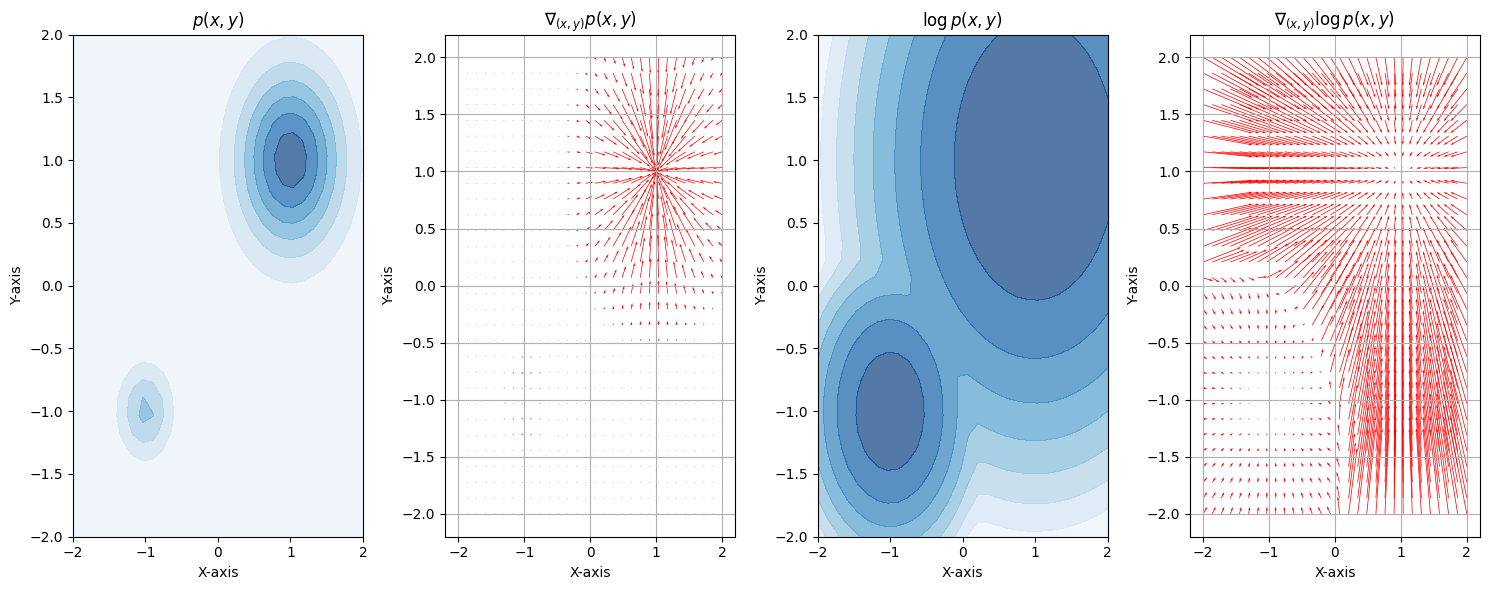

In [ ]:
mu1 = np.array([1.0, 1.0])
mu2 = np.array([-1.0, -1.0])

# Create the grid of points
x = np.linspace(-2, 2, 30)
y = np.linspace(-2, 2, 30)
X, Y = np.meshgrid(x, y)
Z1 = prob_density(X, Y, mu1, mu2)
Z2 = log_prob_density(X, Y, mu1, mu2)

# Compute gradient for plots
U0, V0 = grad_p(X, Y, mu1, mu2)
U1, V1 = grad_log_p(X, Y, mu1, mu2)

# Create a figure with two subplots
fig, axes = plt.subplots(1, 4, figsize=(15, 6))

# Plot 1: Contour plot
contour = axes[0].contourf(X, Y, Z1, cmap='Blues', alpha=0.7)
axes[0].set_title("$p(x,y)$")
axes[0].set_xlabel("X-axis")
axes[0].set_ylabel("Y-axis")

# Plot 2: Quiver plot for the gradient of f
axes[1].quiver(X, Y, U0, V0, color='red', angles='xy', scale_units='xy', scale=0.5, width=0.005)
axes[1].set_title(r"$\nabla_{(x,y)} p(x,y)$")
axes[1].set_xlabel("X-axis")
axes[1].set_ylabel("Y-axis")
axes[1].grid()

# Plot 3: Log Contour plot
contour = axes[2].contourf(X, Y, Z2, cmap='Blues', alpha=0.7)
axes[2].set_title("$\log p(x,y)$")
axes[2].set_xlabel("X-axis")
axes[2].set_ylabel("Y-axis")

# Plot 4: Quiver plot for gradient of log f
axes[3].quiver(X, Y, U1, V1, color='red', angles='xy', scale_units='xy', scale=1, width=0.0025)
axes[3].set_title(r"$\nabla_{(x,y)}\log p(x,y)$")
axes[3].set_xlabel("X-axis")
axes[3].set_ylabel("Y-axis")
axes[3].grid()

# Display the plots
plt.tight_layout()
plt.show()

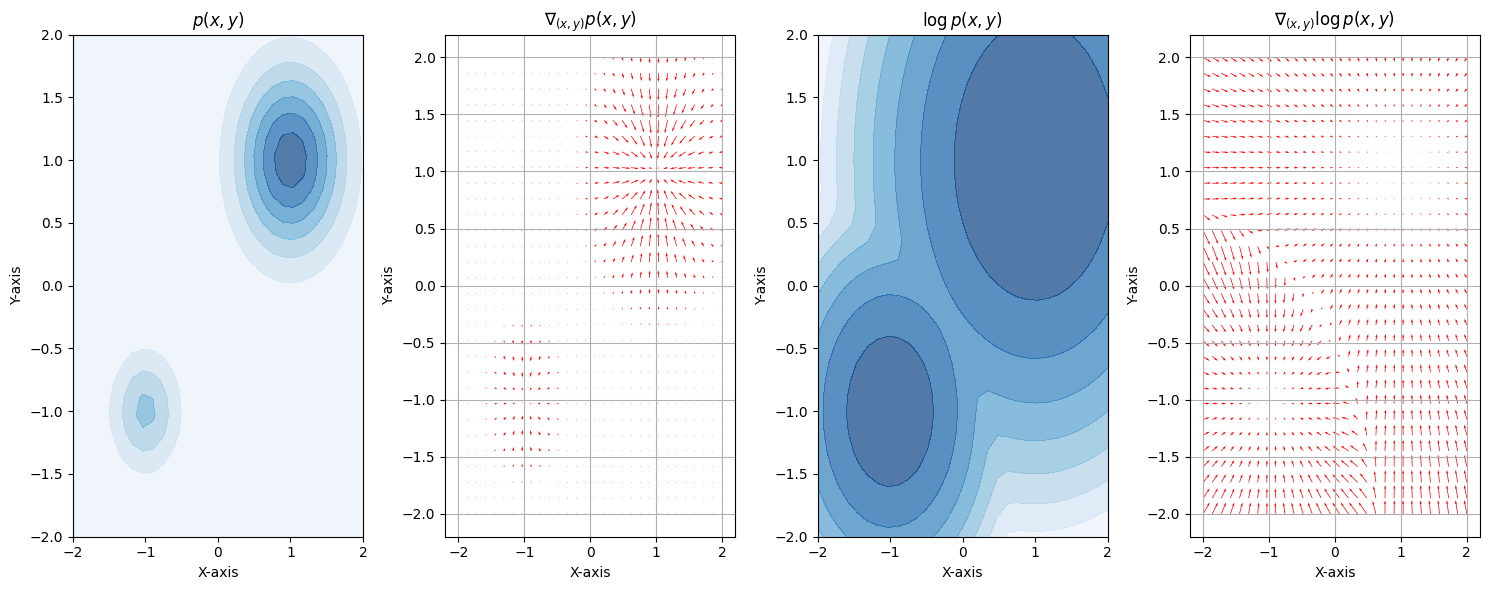

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the function for plot 1
def f(x, y):
    g1 = np.exp(-((x - 1)**2 + (y - 1)**2) / 0.5)  # Bigger, wider peak
    g2 = 0.5 * np.exp(-((x + 1)**2 + (y + 1)**2) / 0.2)  # Smaller, sharper peak
    return g1 + g2

def grad_f(x, y):
    # Compute g1 and g2
    g1 = np.exp(-((x - 1)**2 + (y - 1)**2) / 0.5)
    g2 = 0.5 * np.exp(-((x + 1)**2 + (y + 1)**2) / 0.2)

    # Compute the gradient components
    grad_x = g1 * (-4 * (x - 1)) + g2 * (-5 * (x + 1))
    grad_y = g1 * (-4 * (y - 1)) + g2 * (-5 * (y + 1))

    return grad_x, grad_y

def logf(x, y):
    return np.log(f(x, y))

# Define gradient function for plot 2
def grad_logf(x, y):
    df_dx = -((2*(x-1))/0.5) * np.exp(-((x - 1)**2 + (y - 1)**2) / 0.5) - (((x+1))/0.2) * np.exp(-((x + 1)**2 + (y + 1)**2) / 0.2)
    df_dy = -((2*(y-1))/0.5) * np.exp(-((x - 1)**2 + (y - 1)**2) / 0.5) - (((y+1))/0.2) * np.exp(-((x + 1)**2 + (y + 1)**2) / 0.2)
    return np.array([df_dx/f(x,y), df_dy/f(x,y)])

# Create the grid of points
x = np.linspace(-2, 2, 30)
y = np.linspace(-2, 2, 30)
X, Y = np.meshgrid(x, y)
Z1 = f(X, Y)
Z2 = logf(X, Y)

# Compute gradient for plots
U0, V0 = grad_f(X, Y)
U1, V1 = grad_logf(X, Y)

# Create a figure with two subplots
fig, axes = plt.subplots(1, 4, figsize=(15, 6))

# Plot 1: Contour plot
contour = axes[0].contourf(X, Y, Z1, cmap='Blues', alpha=0.7)
axes[0].set_title("$p(x,y)$")
axes[0].set_xlabel("X-axis")
axes[0].set_ylabel("Y-axis")

# Plot 2: Quiver plot for the gradient of f
axes[1].quiver(X, Y, U0, V0, color='red', angles='xy', scale_units='xy', scale=10, width=0.0025)
axes[1].set_title(r"$\nabla_{(x,y)} p(x,y)$")
axes[1].set_xlabel("X-axis")
axes[1].set_ylabel("Y-axis")
axes[1].grid()

# Plot 3: Log Contour plot
contour = axes[2].contourf(X, Y, Z2, cmap='Blues', alpha=0.7)
axes[2].set_title("$\log p(x,y)$")
axes[2].set_xlabel("X-axis")
axes[2].set_ylabel("Y-axis")

# Plot 4: Quiver plot for gradient of log f
axes[3].quiver(X, Y, U1, V1, color='red', angles='xy', scale_units='xy', scale=100, width=0.0025)
axes[3].set_title(r"$\nabla_{(x,y)}\log p(x,y)$")
axes[3].set_xlabel("X-axis")
axes[3].set_ylabel("Y-axis")
axes[3].grid()

# Display the plots
plt.tight_layout()
plt.show()


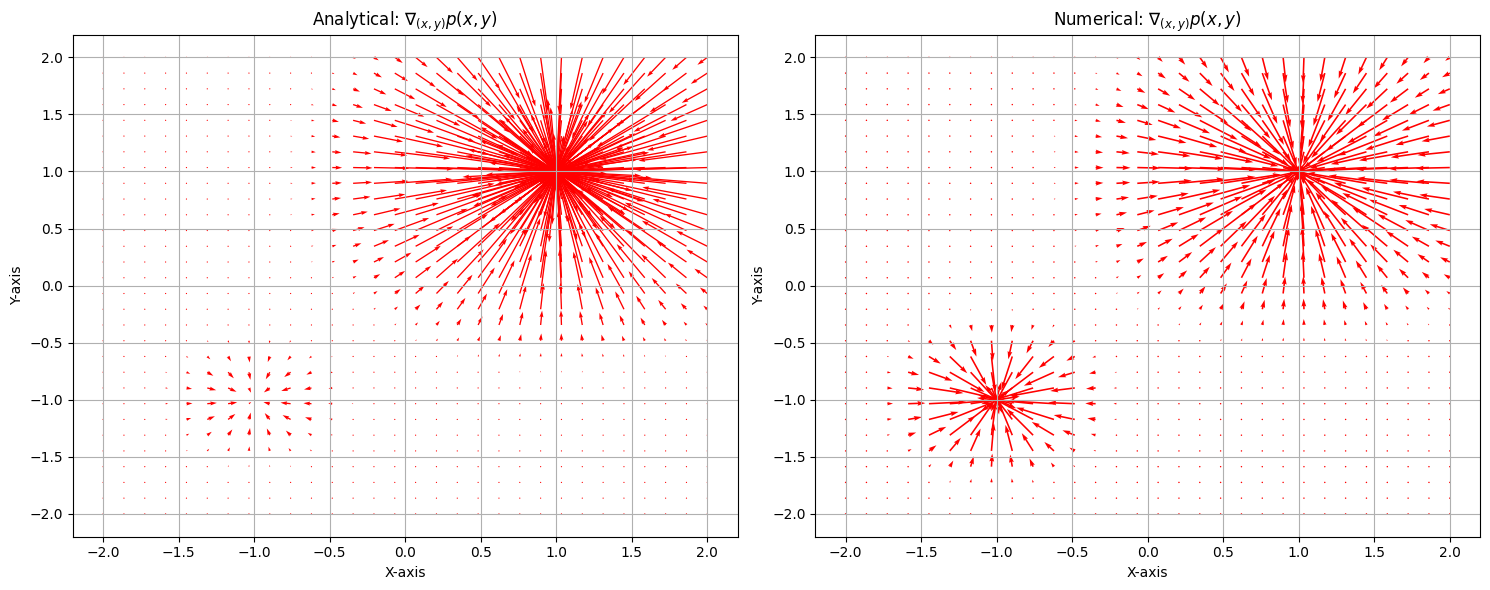

In [ ]:
mu1 = np.array([1.0, 1.0])
mu2 = np.array([-1.0, -1.0])

# Create the grid of points
x = np.linspace(-2, 2, 30)
y = np.linspace(-2, 2, 30)
X, Y = np.meshgrid(x, y)
Z1 = prob_density(X, Y, mu1, mu2)

# Compute gradient for plots
U0, V0 = grad_p(X, Y, mu1, mu2)
U1 = np.gradient(Z1, x, axis=1)
V1 = np.gradient(Z1, y, axis=0)

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Quiver plot for the gradient of f
axes[0].quiver(X, Y, U0, V0, color='red', angles='xy', scale_units='xy', scale=0.07, width=0.002)
axes[0].set_title(r"Analytical: $\nabla_{(x,y)} p(x,y)$")
axes[0].set_xlabel("X-axis")
axes[0].set_ylabel("Y-axis")
axes[0].grid()

# Plot 2: Quiver plot for gradient of log f
axes[1].quiver(X, Y, U1, V1, color='red', angles='xy', scale_units='xy')
axes[1].set_title(r"Numerical: $\nabla_{(x,y)} p(x,y)$")
axes[1].set_xlabel("X-axis")
axes[1].set_ylabel("Y-axis")
axes[1].grid()

# Display the plots
plt.tight_layout()
plt.show()


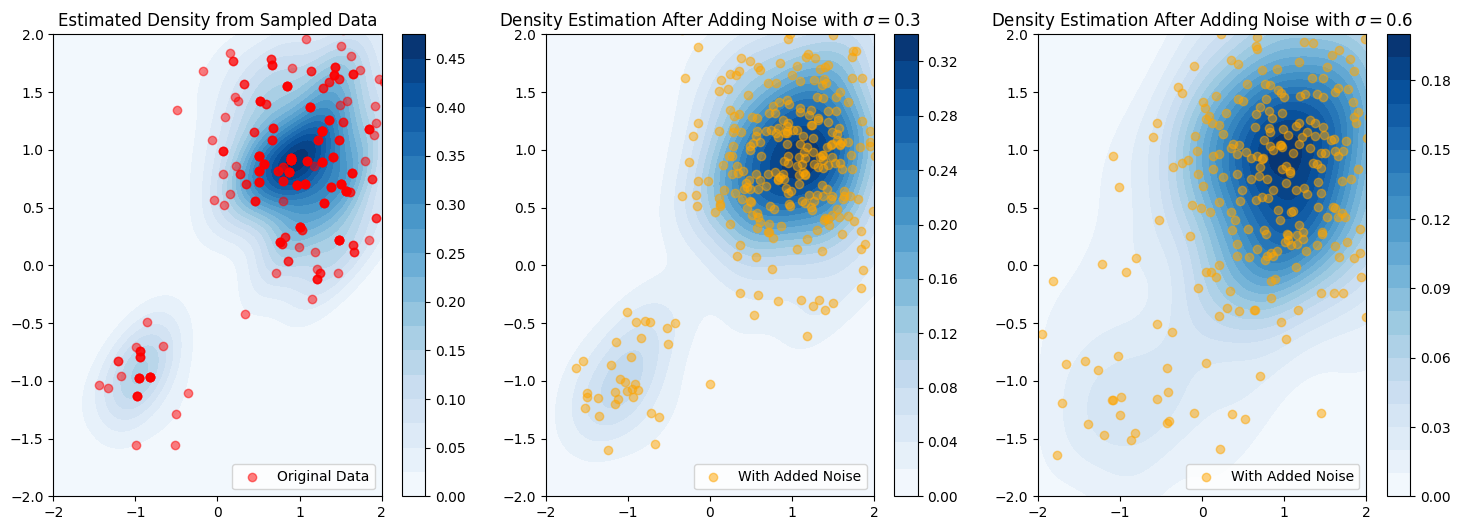

In [ ]:
from scipy.stats import gaussian_kde

# Generate synthetic samples from f(x, y)
np.random.seed(42)
num_samples = 1000
x_samples = np.random.uniform(-3, 3, num_samples)
y_samples = np.random.uniform(-3, 3, num_samples)
probabilities = prob_density(x_samples, y_samples, mu1, mu2)
probabilities /= probabilities.sum()  # Normalize to sum to 1

# Sample points according to probability distribution
indices = np.random.choice(range(num_samples), size=300, p=probabilities)
data = np.column_stack((x_samples[indices], y_samples[indices]))

# Add Gaussian noise
noise_std_1 = 0.3
noise_std_2 = 0.6

data_noisy_1 = data + np.random.normal(scale=noise_std_1, size=data.shape)
data_noisy_2 = data + np.random.normal(scale=noise_std_2, size=data.shape)

# Estimate density using KDE (from sampled points)
kde_original = gaussian_kde(data.T)
kde_noisy_1 = gaussian_kde(data_noisy_1.T)
kde_noisy_2 = gaussian_kde(data_noisy_2.T)

# Create grid for density visualization
x_range = np.linspace(-3, 3, num_samples)
y_range = np.linspace(-3, 3, num_samples)
X, Y = np.meshgrid(x_range, y_range)
positions = np.vstack([X.ravel(), Y.ravel()])
Z_original = np.reshape(kde_original(positions), X.shape)
Z_noisy_1 = np.reshape(kde_noisy_1(positions), X.shape)
Z_noisy_2 = np.reshape(kde_noisy_2(positions), X.shape)

# Plot KDE-based density estimation
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

contour1 = ax[0].contourf(X, Y, Z_original, levels=20, cmap="Blues")
ax[0].scatter(data[:, 0], data[:, 1], color="red", alpha=0.5, label="Original Data")
ax[0].set_title("Estimated Density from Sampled Data")
ax[0].set_xlim([-2, 2])
ax[0].set_ylim([-2, 2])
ax[0].legend(loc = "lower right")
fig.colorbar(contour1, ax=ax[0])

contour2 = ax[1].contourf(X, Y, Z_noisy_1, levels=20, cmap="Blues")
ax[1].scatter(data_noisy_1[:, 0], data_noisy_1[:, 1], color="orange", alpha=0.5, label="With Added Noise")
ax[1].set_title("Density Estimation After Adding Noise with $\sigma = 0.3$")
ax[1].set_xlim([-2, 2])
ax[1].set_ylim([-2, 2])
ax[1].legend(loc = "lower right")
fig.colorbar(contour2, ax=ax[1])

contour3 = ax[2].contourf(X, Y, Z_noisy_2, levels=20, cmap="Blues")
ax[2].scatter(data_noisy_2[:, 0], data_noisy_2[:, 1], color="orange", alpha=0.5, label="With Added Noise")
ax[2].set_title("Density Estimation After Adding Noise with $\sigma = 0.6$")
ax[2].set_xlim([-2, 2])
ax[2].set_ylim([-2, 2])
ax[2].legend(loc = "lower right")
fig.colorbar(contour3, ax=ax[2])

plt.show()

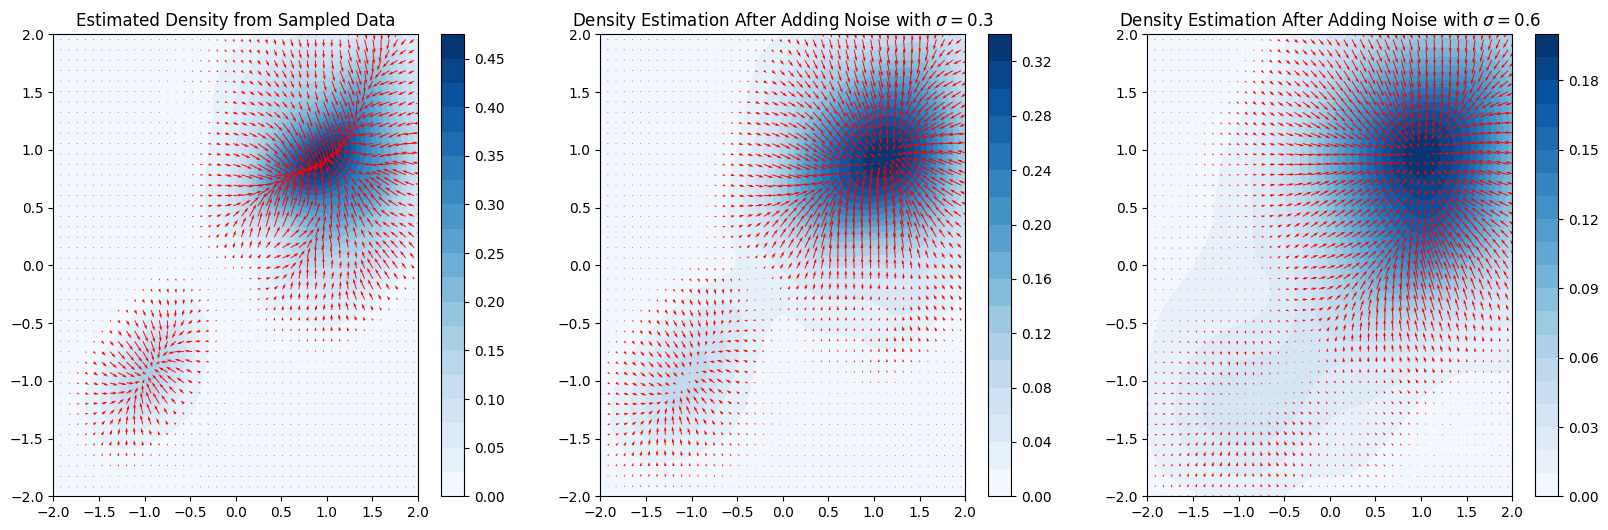

In [ ]:
# Compute gradient of log-density using finite differences
def gradient_f(x,y,z):
    df_dx = np.gradient(z, x, axis=1)
    df_dy = np.gradient(z, y, axis=0)

    return df_dx, df_dy

grad_x_original, grad_y_original = gradient_f(x_range, y_range, Z_original)
grad_x_noisy_1, grad_y_noisy_1 = gradient_f(x_range, y_range, Z_noisy_1)
grad_x_noisy_2, grad_y_noisy_2 = gradient_f(x_range, y_range, Z_noisy_2)

# Define step size for downsampling
step = 15

# Plot contour and quiver with fewer arrows
fig, ax = plt.subplots(1, 3, figsize=(20, 6))

contour1 = ax[0].contourf(X, Y, Z_original, levels=20, cmap="Blues")
ax[0].quiver(X[::step, ::step], Y[::step, ::step],
             grad_x_original[::step, ::step], grad_y_original[::step, ::step],
             color='red', angles='xy', scale_units='xy', scale=3, width=0.0025)
ax[0].set_title("Estimated Density from Sampled Data")
ax[0].set_xlim([-2, 2])
ax[0].set_ylim([-2, 2])
fig.colorbar(contour1, ax=ax[0])

contour2 = ax[1].contourf(X, Y, Z_noisy_1, levels=20, cmap="Blues")
ax[1].quiver(X[::step, ::step], Y[::step, ::step],
             grad_x_noisy_1[::step, ::step], grad_y_noisy_1[::step, ::step],
             color='red', angles='xy', scale_units='xy', scale=2, width=0.0025)
ax[1].set_title("Density Estimation After Adding Noise with $\sigma = 0.3$")
ax[1].set_xlim([-2, 2])
ax[1].set_ylim([-2, 2])
fig.colorbar(contour2, ax=ax[1])

contour3 = ax[2].contourf(X, Y, Z_noisy_2, levels=20, cmap="Blues")
ax[2].quiver(X[::step, ::step], Y[::step, ::step],
             grad_x_noisy_2[::step, ::step], grad_y_noisy_2[::step, ::step],
             color='red', angles='xy', scale_units='xy', scale=1, width=0.0025)
ax[2].set_title("Density Estimation After Adding Noise with $\sigma = 0.6$")
ax[2].set_xlim([-2, 2])
ax[2].set_ylim([-2, 2])
fig.colorbar(contour3, ax=ax[2])

plt.show()


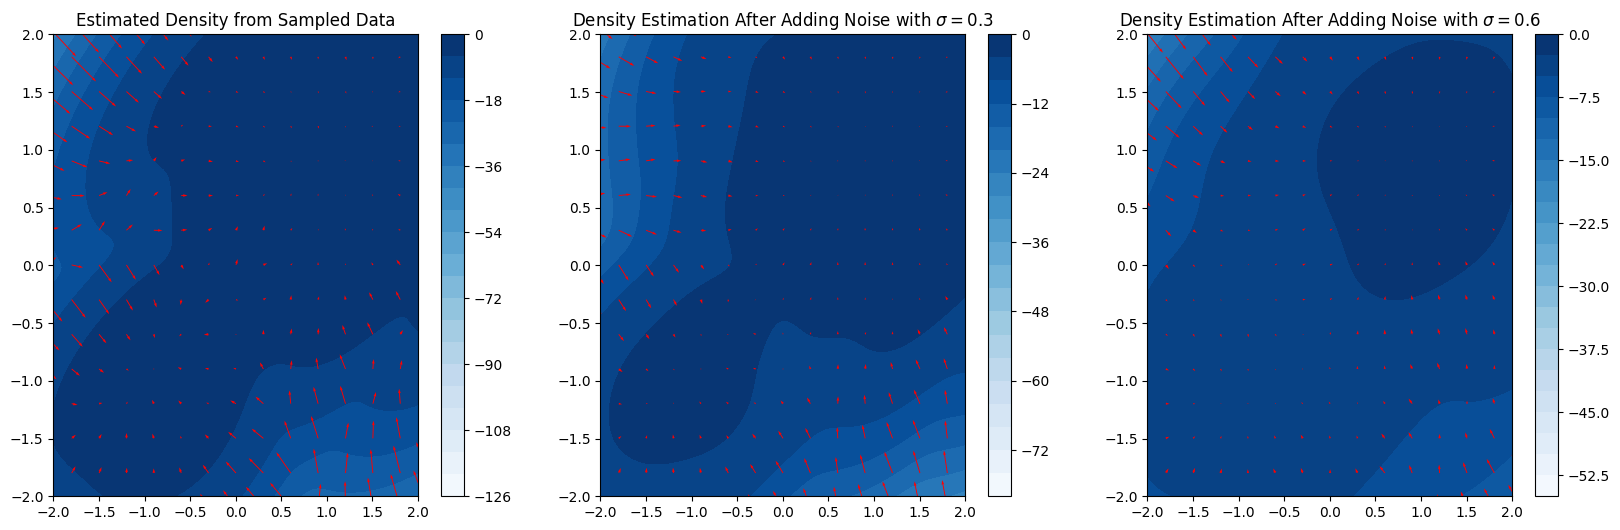

In [ ]:
logZ_original = np.log(Z_original)
logZ_noisy_1 = np.log(Z_noisy_1)
logZ_noisy_2 = np.log(Z_noisy_2)

grad_logx_original, grad_logy_original = gradient_f(x_range, y_range, logZ_original)
grad_logx_noisy_1, grad_logy_noisy_1 = gradient_f(x_range, y_range, logZ_noisy_1)
grad_logx_noisy_2, grad_logy_noisy_2 = gradient_f(x_range, y_range, logZ_noisy_2)

X, Y = np.meshgrid(x_range, y_range)

# Define step size for downsampling
step = 50

# Plot contour and quiver with fewer arrows
fig, ax = plt.subplots(1, 3, figsize=(20, 6))

contour1 = ax[0].contourf(X, Y, logZ_original, levels=20, cmap="Blues")
ax[0].quiver(X[::step, ::step], Y[::step, ::step],
             grad_logx_original[::step, ::step], grad_logy_original[::step, ::step],
             color='red', angles='xy', scale_units='xy', scale=100, width=0.0025)
ax[0].set_title("Estimated Density from Sampled Data")
ax[0].set_xlim([-2, 2])
ax[0].set_ylim([-2, 2])
fig.colorbar(contour1, ax=ax[0])

contour2 = ax[1].contourf(X, Y, logZ_noisy_1, levels=20, cmap="Blues")
ax[1].quiver(X[::step, ::step], Y[::step, ::step],
             grad_logx_noisy_1[::step, ::step], grad_logy_noisy_1[::step, ::step],
             color='red', angles='xy', scale_units='xy', scale=100, width=0.0025)
ax[1].set_title("Density Estimation After Adding Noise with $\sigma = 0.3$")
ax[1].set_xlim([-2, 2])
ax[1].set_ylim([-2, 2])
fig.colorbar(contour2, ax=ax[1])

contour3 = ax[2].contourf(X, Y, logZ_noisy_2, levels=20, cmap="Blues")
ax[2].quiver(X[::step, ::step], Y[::step, ::step],
             grad_logx_noisy_2[::step, ::step], grad_logy_noisy_2[::step, ::step],
             color='red', angles='xy', scale_units='xy', scale=50, width=0.0025)
ax[2].set_title("Density Estimation After Adding Noise with $\sigma = 0.6$")
ax[2].set_xlim([-2, 2])
ax[2].set_ylim([-2, 2])
fig.colorbar(contour3, ax=ax[2])

plt.show()


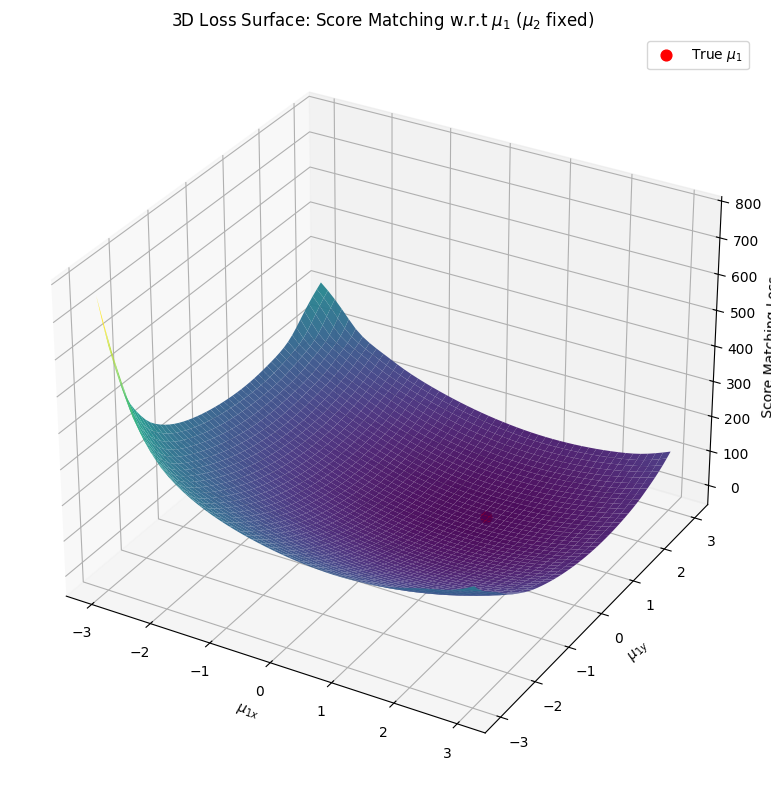

In [ ]:
# -----------------------------
# 2. Score Matching Loss
# -----------------------------

def score_matching_loss(x, y, mu1, mu2, sigma1=0.5, sigma2=0.25, alpha=0.5):
    # Get the gradient of log p
    dlogp_dx, dlog_dy = grad_log_p(x, y, mu1, mu2, sigma1, sigma2, alpha)

    # Get the laplacian of log p
    laplacian = laplacian_log_p(x, y, mu1, mu2, sigma1, sigma2, alpha)

    # Compute the score matching loss
    score_loss = 0.5 * (dlogp_dx**2 + dlog_dy**2) + laplacian

    return score_loss

# -----------------------------
# 3. Create Sample Data (From True Distribution)
# -----------------------------
np.random.seed(0)
n_samples = 200
true_mu1 = np.array([1.0, 1.0])
true_mu2 = np.array([-1.0, -1.0])
true_sigma1 = 0.5
true_sigma2 = 0.25

# Generate samples from a mixture of Gaussians
samples = []
for _ in range(n_samples):
    if np.random.rand() < 0.7:
        samples.append(np.random.multivariate_normal(true_mu1, true_sigma1**2 * np.eye(2)))
    else:
        samples.append(np.random.multivariate_normal(true_mu2, true_sigma2**2 * np.eye(2)))
samples = np.array(samples)
x_data = samples[:, 0]
y_data = samples[:, 1]

# -----------------------------
# 4. Evaluate Score Matching Loss over Grid
# -----------------------------
grid_range = np.linspace(-3, 3, 50)
mu1x_grid, mu1y_grid = np.meshgrid(grid_range, grid_range)
loss_surface = np.zeros_like(mu1x_grid)

# Fix mu2 for now (optimize wrt mu1 only)
mu2_fixed = np.array([-1.0, -1.0])

for i in range(mu1x_grid.shape[0]):
    for j in range(mu1x_grid.shape[1]):
        mu1_try = np.array([mu1x_grid[i, j], mu1y_grid[i, j]])
        total_loss = 0
        for x_, y_ in zip(x_data, y_data):
            total_loss += score_matching_loss(x_, y_, mu1_try, mu2_fixed)
        loss_surface[i, j] = total_loss / len(x_data)

# -----------------------------
# 5. Plot Loss Surface
# -----------------------------
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(mu1x_grid, mu1y_grid, loss_surface, cmap='viridis', edgecolor='none', alpha=0.95)
ax.set_xlabel(r"$μ_{1x}$")
ax.set_ylabel(r"$μ_{1y}$")
ax.set_zlabel("Score Matching Loss")
ax.set_title(r"3D Loss Surface: Score Matching w.r.t $μ_1$ ($μ_2$ fixed)")
ax.scatter(true_mu1[0], true_mu1[1], np.min(loss_surface), c='red', s=60, label=r'True $μ_1$')

ax.legend()
plt.tight_layout()
plt.show()

In [ ]:
from scipy.optimize import minimize

def objective(mu1_vec):
    mu1 = np.array(mu1_vec)
    total_loss = 0
    for x_, y_ in zip(x_data, y_data):
        total_loss += score_matching_loss(x_, y_, mu1, mu2_fixed)
    return total_loss / len(x_data)

# Start from a random initialization
init_guess = np.random.uniform(-3, 3, size=2)

# Run optimization
res = minimize(objective, init_guess, method='BFGS')

# ---------- Output Results ----------
print("Optimized μ1 (minimizer):", res.x)
print("Loss at optimum:", res.fun)
print("True μ1 (used to generate data):", true_mu1)

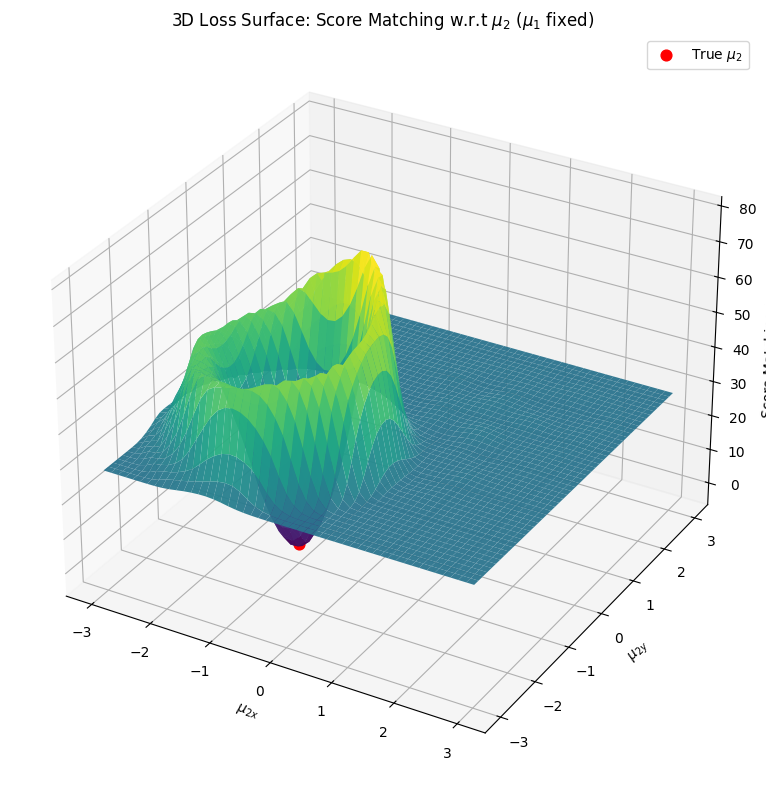

In [ ]:
# -----------------------------
# 2. Score Matching Loss
# -----------------------------

def score_matching_loss(x, y, mu1, mu2, sigma1=0.5, sigma2=0.25, alpha=0.5):
    # Get the gradient of log p
    dlogp_dx, dlog_dy = grad_log_p(x, y, mu1, mu2, sigma1, sigma2, alpha)

    # Get the laplacian of log p
    laplacian = laplacian_log_p(x, y, mu1, mu2, sigma1, sigma2, alpha)

    # Compute the score matching loss
    score_loss = 0.5 * (dlogp_dx**2 + dlog_dy**2) + laplacian

    return score_loss

# -----------------------------
# 3. Create Sample Data (From True Distribution)
# -----------------------------
np.random.seed(0)
n_samples = 200
true_mu1 = np.array([1.0, 1.0])
true_mu2 = np.array([-1.0, -1.0])
true_sigma1 = 0.5
true_sigma2 = 0.25

# Generate samples from a mixture of Gaussians
samples = []
for _ in range(n_samples):
    if np.random.rand() < 0.7:
        samples.append(np.random.multivariate_normal(true_mu1, true_sigma1**2 * np.eye(2)))
    else:
        samples.append(np.random.multivariate_normal(true_mu2, true_sigma2**2 * np.eye(2)))
samples = np.array(samples)
x_data = samples[:, 0]
y_data = samples[:, 1]

# -----------------------------
# 4. Evaluate Score Matching Loss over Grid
# -----------------------------
grid_range = np.linspace(-3, 3, 50)
mu2x_grid, mu2y_grid = np.meshgrid(grid_range, grid_range)
loss_surface = np.zeros_like(mu2x_grid)

# Fix mu1 for now (optimize wrt mu2 only)
mu1_fixed = np.array([1.0, 1.0])

for i in range(mu2x_grid.shape[0]):
    for j in range(mu2x_grid.shape[1]):
        mu2_try = np.array([mu2x_grid[i, j], mu2y_grid[i, j]])
        total_loss = 0
        for x_, y_ in zip(x_data, y_data):
            total_loss += score_matching_loss(x_, y_, mu1_fixed, mu2_try)
        loss_surface[i, j] = total_loss / len(x_data)

# -----------------------------
# 5. Plot Loss Surface
# -----------------------------
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(mu2x_grid, mu2y_grid, loss_surface, cmap='viridis', edgecolor='none', alpha=0.95)
ax.set_xlabel(r"$μ_{2x}$")
ax.set_ylabel(r"$μ_{2y}$")
ax.set_zlabel("Score Matching Loss")
ax.set_title(r"3D Loss Surface: Score Matching w.r.t $μ_2$ ($μ_1$ fixed)")
ax.scatter(true_mu2[0], true_mu2[1], np.min(loss_surface), c='red', s=60, label=r'True $μ_2$')

ax.legend()
plt.tight_layout()
plt.show()

In [ ]:
# -----------------------------
# 4b. Compute the numerical minimum of the loss surface
# -----------------------------
min_index = np.unravel_index(np.argmin(loss_surface), loss_surface.shape)
mu2_min = np.array([mu2x_grid[min_index], mu2y_grid[min_index]])
min_loss = loss_surface[min_index]

print("Optimal μ2 (from grid search):", mu2_min)
print("Minimum Score Matching Loss:", min_loss)

Optimal μ2 (from grid search): [-1.04081633 -1.04081633]
Minimum Score Matching Loss: -0.856490446270291


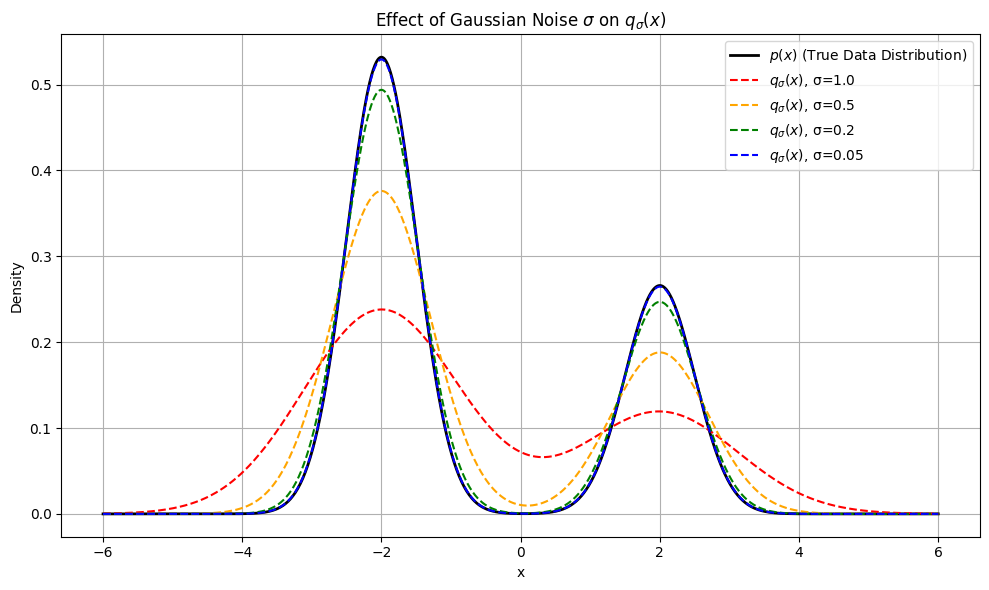

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Define the true data distribution p(x): a mixture of Gaussians
def p_x(x):
    return (2/3) * norm.pdf(x, loc=-2, scale=0.5) + (1/3) * norm.pdf(x, loc=2, scale=0.5)

# Define q_sigma(x): convolution of p(x) with Gaussian noise N(0, sigma^2)
def q_sigma_x(x, sigma, xs):
    conv = np.zeros_like(x)
    for xi in xs:
        conv += p_x(xi) * norm.pdf(x, loc=xi, scale=sigma)
    conv /= np.sum(p_x(xs))  # normalization (approximate)
    return conv

# Plotting
x_vals = np.linspace(-6, 6, 1000)
p_vals = p_x(x_vals)

# Different values of sigma to show how q_sigma(x) approaches p(x) as sigma → 0
sigmas = [1.0, 0.5, 0.2, 0.05]
colors = ['red', 'orange', 'green', 'blue']

plt.figure(figsize=(10, 6))
plt.plot(x_vals, p_vals, label=r'$p(x)$ (True Data Distribution)', color='black', linewidth=2)

for sigma, color in zip(sigmas, colors):
    q_vals = q_sigma_x(x_vals, sigma, x_vals)
    plt.plot(x_vals, q_vals, label=f'$q_σ(x)$, σ={sigma}', color=color, linestyle='--')

plt.title(r'Effect of Gaussian Noise $\sigma$ on $q_{\sigma}(x)$')
plt.xlabel('x')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

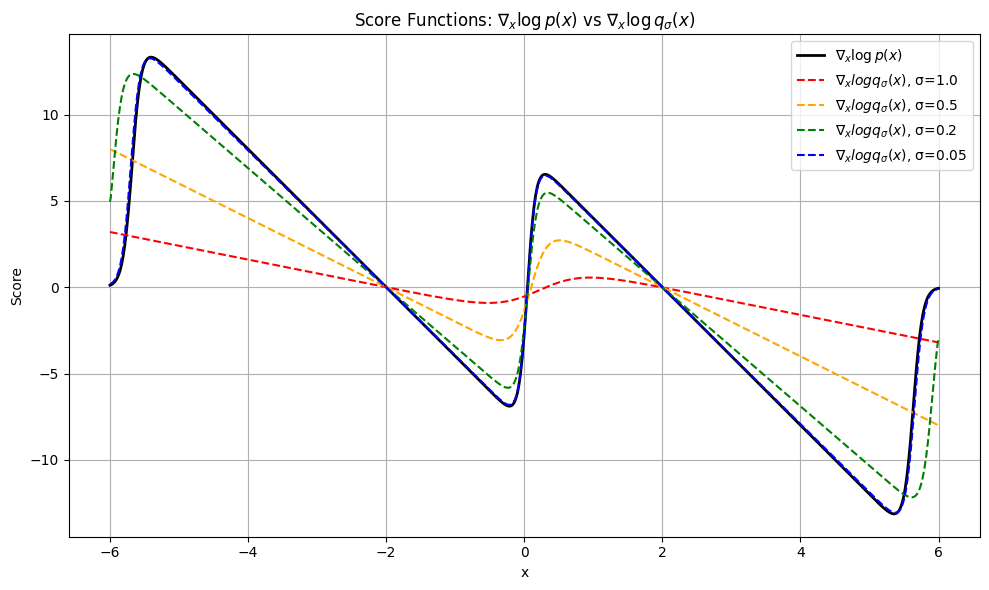

In [ ]:
# Compute gradient (score) of log p(x)
def score_p_x(x, dx=1e-4):
    log_p = np.log(p_x(x) + 1e-12)  # avoid log(0)
    dlog_p = np.gradient(log_p, dx)
    return dlog_p

# Compute gradient (score) of log q_sigma(x)
def score_q_sigma_x(x, sigma, xs, dx=1e-4):
    q_vals = q_sigma_x(x, sigma, xs)
    log_q = np.log(q_vals + 1e-12)
    dlog_q = np.gradient(log_q, dx)
    return dlog_q

# Set up x values
x_vals = np.linspace(-6, 6, 1000)
dx = x_vals[1] - x_vals[0]
sigmas = [1.0, 0.5, 0.2, 0.05]
colors = ['red', 'orange', 'green', 'blue']

# Compute and plot the score functions
plt.figure(figsize=(10, 6))
score_p = score_p_x(x_vals, dx=dx)
plt.plot(x_vals, score_p, label=r'$\nabla_x\log p(x)$', color='black', linewidth=2)

for sigma, color in zip(sigmas, colors):
    score_q = score_q_sigma_x(x_vals, sigma, x_vals, dx=dx)
    plt.plot(x_vals, score_q, label=f'$∇_xlog q_σ(x)$, σ={sigma}', color=color, linestyle='--')

plt.title(r'Score Functions: $\nabla_x\log p(x)$ vs $\nabla_x\log q_\sigma(x)$')
plt.xlabel('x')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Score Diffusion Models

## Mixture of Gaussians

Using Gaussian Mixture dataset, with parameters mean=[-0.5, 0.0], [0.5, 0.0] and std=0.1. 10000 samples.
Number of samples for the first gaussian: 5000
Number of samples for the second gaussian: 5000


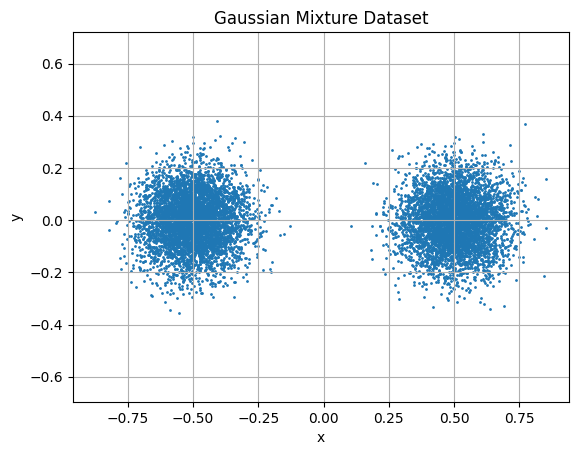

In [ ]:
import torch
import matplotlib.pyplot as plt

# Create a dataset with a Gaussian mixture distribution:
def get_gaussian_mixture_datapoints(mean1, mean2, std, n_samples):
    print('Using Gaussian Mixture dataset, with parameters mean=[{}, {}], [{}, {}] and std={}. {} samples.'
          .format(mean1[0], mean1[1], mean2[0], mean2[1], std, n_samples))
    # Decide that number of samples from each gaussian according to some ratio
    ratio = 0.5
    n_samples_1 = round(n_samples * ratio)
    n_samples_2 = n_samples - n_samples_1

    print(f"Number of samples for the first gaussian: {n_samples_1}")
    print(f"Number of samples for the second gaussian: {n_samples_2}")

    # Generate the samples for each gaussian
    samples1 = torch.randn(n_samples_1, 2) * std + mean1
    samples2 = torch.randn(n_samples_2, 2) * std + mean2
    samples = torch.concatenate([samples1, samples2], dim=0)
    return samples

def get_default_gaussian_mixture_datapoints():
    mean1 = torch.tensor([-0.5, 0])
    mean2 = torch.tensor([0.5, 0])
    std = 0.1
    n_samples = 10000
    gaussian_datapoints = get_gaussian_mixture_datapoints(mean1, mean2, std, n_samples)
    gaussian_datapoints = gaussian_datapoints[torch.randperm(n_samples)]
    return gaussian_datapoints

# random shuffle
gaussian_datapoints = get_default_gaussian_mixture_datapoints()

# plot the Gaussian mixture dataset
plt.scatter(gaussian_datapoints[:, 0], gaussian_datapoints[:, 1], s=1)
plt.axis('equal')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Gaussian Mixture Dataset')
plt.grid(True)
plt.show()


In [ ]:
# Create a TensorDataset
def create_dataset(datapoints):

    labels = torch.zeros(datapoints.shape[0])
    dataset_obj = torch.utils.data.TensorDataset(datapoints, labels)
    return dataset_obj

def create_dataloader(dataset, batch_size):
    # Create a DataLoader
    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True
        )
    return dataloader


gaussian_datapoints = get_default_gaussian_mixture_datapoints()
dataset_obj = create_dataset(gaussian_datapoints)
dataloader = create_dataloader(dataset_obj, batch_size=500)

Using Gaussian Mixture dataset, with parameters mean=[-0.5, 0.0], [0.5, 0.0] and std=0.1. 10000 samples.
Number of samples for the first gaussian: 5000
Number of samples for the second gaussian: 5000


### $\alpha_t$ and $\beta_t$:

Implement two noise schedule:
* **linear noise schedule** $\beta_t$ scales linearly from $\beta_{min} = 0.1$ to $\beta_{max} = 20.0$.
* **cosine noise schedule** Directly parameterize $\bar \alpha_t$ as
$$\bar \alpha_t = \cos\left(\frac{\bar t + s}{2(1 + s)} \pi\right)^2,$$
where $s = 0.008$ and $\bar  t = t / T$. (TENGO QUE MIRAR ESTE DE AQUI QUE ONDA!!!)

### Forward : sample $p_{t | 0}$

$$
  x_t = \sqrt{\overline{\alpha}_t} x_0 + \sqrt{1-\overline{\alpha}_t} \epsilon
$$

In [ ]:
import math

def match_last_dims(data, shape):
    """
    Repeat a 1D tensor so that its last dimensions [1:] match `size[1:]`.
    Useful for working with batched data.
    """
    assert len(data.shape) == 1, "Data must be 1-dimensional (one value per batch)"
    for _ in range(len(shape) - 1):
        data = data.unsqueeze(-1)
    return data.repeat(1, *(shape[1:]))

def compute_beta_t(t_norm, T, schedule = 'linear'):
    # Compute β(t) depending on schedule.

    if schedule == 'linear':
        beta_min = 0.1
        beta_max = 20.0
        beta_t = beta_min + t_norm * (beta_max - beta_min)
    elif schedule == 'cosine':
        s = 0.008
        val = ((t_norm+s) / (1 + s)) * (math.pi / 2)
        beta_t = (math.pi / (1 + s)) * torch.sin(val)
    else:
        raise ValueError('Unknown schedule')
    return beta_t

def compute_alpha_bar(t_norm, schedule = 'linear'):
    if schedule == 'linear':
        beta_min = 0.1
        beta_max = 20.0
        integrated_beta = beta_min * t_norm + 0.5 * (beta_max - beta_min) * t_norm**2
        alpha_bar = torch.exp(-  integrated_beta)
    elif schedule == 'cosine':
        alpha_bar = 0.5 * (1 - torch.cos(t_norm * torch.pi))
        s = 0.008
        alpha_bar = torch.cos((t_norm + s) / (1 + s) * (torch.pi / 2))**2
    else:
        raise ValueError('Unknown schedule')
    return alpha_bar

# must return x_t and the added noise, we will need it later to compute the loss
def forward(x_start, t, T, schedule = 'linear'):
    t_norm = t / T
    alpha_bar = compute_alpha_bar(t_norm, schedule)
    # expand alpha_bar to the same shape as x_start, so that we can multiply them
    alpha_bar = match_last_dims(alpha_bar, x_start.shape)
    noise = torch.randn_like(x_start)
    x_t = torch.sqrt(alpha_bar)*x_start + torch.sqrt(1 - alpha_bar)*noise
    return x_t, noise

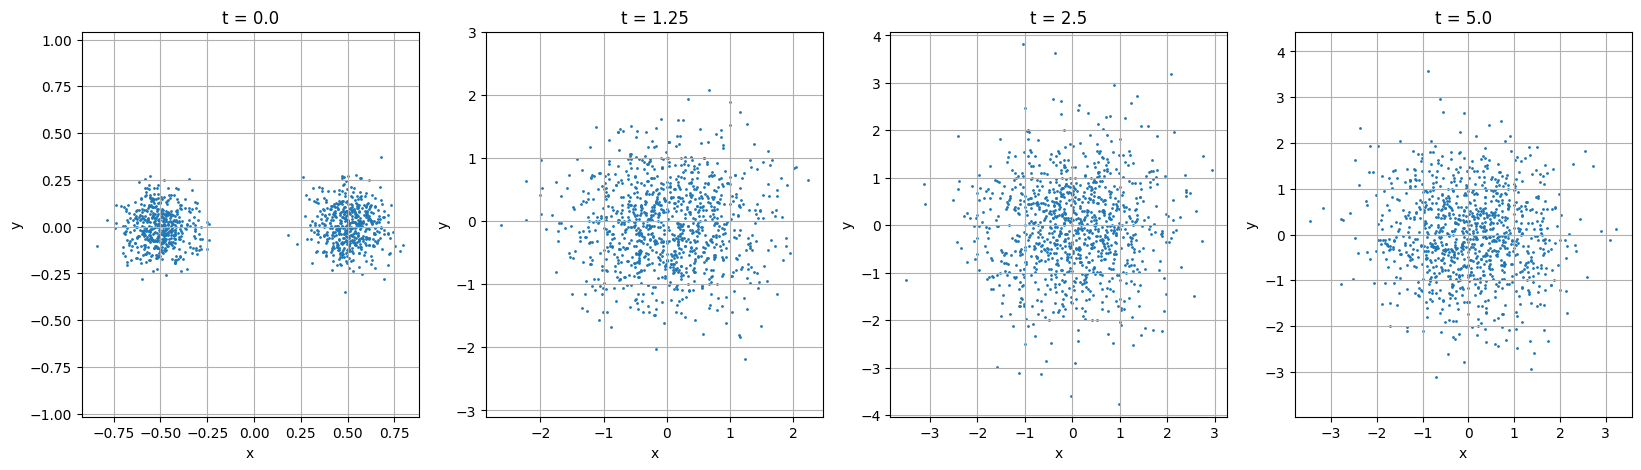

In [ ]:
# check the forward process by plotting the empirical marginals p_t, for some t and empirical samples
x_start = dataset_obj[:1000][0]

# create four subplots
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

# plot the empirical marginals p_t
def plot_ax_i(ax, x, y, title):
    ax.scatter(x, y, s=1)
    ax.axis('equal')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.grid(True)
    ax.set_title(title)

T = 5

for i, t_norm in enumerate([0.0, 0.25, 0.5, 1.0]):
    t = t_norm * T * torch.ones_like(x_start)[:, 0]
    x_t, _ = forward(x_start, t, T)
    plot_ax_i(axs[i], x_t[:, 0], x_t[:, 1], 't = {}'.format(t[0]))

plt.show()

### Loss functions

1. The first possibility for the training loss is predicting directly the noise added to the image:

$$
  \mathcal{L}_ϵ(θ) = \mathbb{E} \left[|| \overline{ϵ}_t-\hat{ϵ}_t^θ(X_t)||^2 \right]
$$

In [ ]:
import torch.nn.functional as F

def noise_loss(model, x_start, T):
    x_start = x_start.to(device)
    batch_size = x_start.shape[0]
    # Sample t uniformly from [0, T]
    t = torch.rand(batch_size, device=device) * T
    x_t, noise = forward(x_start, t, T)
    # The model takes x_t and t as input and predicts the noise. time t should be of shape (batch_size, 1)
    # we can pass normalized time to model as input
    t_norm = t / T
    t_norm = t_norm.view(-1, 1)
    predicted_noise = model(x_t, t_norm)
    loss = F.mse_loss(predicted_noise, noise)
    return loss

2. Another possibility is use the score function $∇_x\log p(x)$ as loss function,

$$
  \mathcal{L}_{DSM}(θ) = \mathbb{E} \left[|| s_θ(X_t,t) + \frac{ϵ}{\sqrt{1-\overline{α}_t}}||^2 \right]
$$

In [ ]:
import torch.nn.functional as F

# THIS FUNCTION DOES NOT WORK, WHY?????

def score_loss(model, x_start, T):
    x_start = x_start.to(device)
    batch_size = x_start.shape[0]

    # Sample t uniformly from [0, T]
    t = torch.rand(batch_size, device=device) * T
    t_norm = t / T
    t_norm = t_norm.view(-1, 1)

    # Forward diffusion: get x_t and true noise
    x_t, noise = forward(x_start, t, T)

    # Compute the true score: ∇ₓ log p(x_t | x₀) for VP = -noise / sqrt(1 - alpha_bar)
    alpha_bar = compute_alpha_bar(t_norm).view(-1, *([1] * (x_start.dim() - 1)))
    true_score = -noise / torch.sqrt(1 - alpha_bar)

    # Compute predicted
    predicted_score = model(x_t, t_norm)

    # print(f"predicted_score: {predicted_score} - true_score: {true_score}")

    # MSE between predicted and true score
    loss = F.mse_loss(predicted_score, true_score)

    return loss

3. Their is also the alternative of the ELBO Loss minimizing the KL Divergence:

$$
  \mathcal{L}_{ELBO}(θ) = \mathbb{E}\left[ ||\hat{m}_t^{θ}(X_t) - \tilde{m}_t(X_t,X_0)||^2 \right]
$$

with

$$
  \tilde{m}_t(x_t, \overline{ϵ}_t) = \frac{1}{\sqrt{α_t}}\left( x_t - \frac{1-α_t}{\sqrt{1-\overline{α}_t}} \overline{ϵ}_t \right)
$$

In [ ]:
def elbo_loss(model, x_start, T):
    x_start = x_start.to(device)
    batch_size = x_start.shape[0]

    # Sample t uniformly from [0, T]
    t = torch.rand(batch_size, device=x_start.device) * T
    t_norm = t / T
    t_norm = t_norm.view(-1, 1)

    # Forward diffusion: get x_t and the true noise
    x_t, noise = forward(x_start, t, T)

    # Compute the true mean
    beta_t = compute_beta_t(t_norm, T).view(-1, *([1] * (x_start.dim() - 1)))
    alpha_t = 1 - beta_t
    alpha_bar = compute_alpha_bar(t_norm).view(-1, *([1] * (x_start.dim() - 1)))

    true_mean = (x_t - (1 - alpha_bar)/torch.sqrt(1 - alpha_bar)*noise)/torch.sqrt(alpha_bar)

    # Get the predicted mean
    predicted_mean = model(x_t, t_norm)

    # MSE between predicted and true mean
    loss = F.mse_loss(predicted_mean, true_mean)

    return loss

4. Finally, we can minimize the $X_t$ itself:

$$
  \mathcal{L}_{X_t}(θ) = \mathbb{E}\left[ ||\hat{X}_t^θ - X_t||^2 \right]
$$

In [ ]:
import torch.nn.functional as F

def noise_loss(model, x_start, T):
    x_start = x_start.to(device)
    batch_size = x_start.shape[0]
    t = torch.rand(batch_size, device=x_start.device) * T
    t_norm = t / T

    # Get forward process X_t
    x_t, _ = forward(x_start, t, T)

    # Model predicts X_t directly from x_start and time
    predicted_xt = model(x_start, t_norm)

    # MSE loss between predicted and true X_t
    loss = F.mse_loss(predicted_xt, x_t)
    return loss

Finally, we create a function to pick each of them.

In [ ]:
def loss_fn(model, x_start, T, loss_schedule):
    if loss_schedule == 'noise':
        return noise_loss(model, x_start, T)
    elif loss_schedule == 'score':
        return score_loss(model, x_start, T)
    elif loss_schedule == 'elbo':
        return elbo_loss(model, x_start, T)
    elif loss_schedule == 'xt':
        return noise_loss(model, x_start, T)
    else:
        raise ValueError('Unknown schedule')

### Learning schedule

The scheduler is giving me weird sampling so I should take a look to it.

In [ ]:
def learning_schedule(epoch, learning_rate=0.001, exp_decay=0.1):
    return learning_rate * math.exp(-exp_decay * epoch)

### Neural Network

For this really easy problem we don't really need a very complex neural network, we will just use this simple MLP

In [ ]:
from utils.SimpleModel import MLPModel

# define a simple MLP model.
simple_model = MLPModel(
    nfeatures = 2,
    time_emb_size= 8,
    nblocks = 4,
    nunits = 32,
    skip_connection = True,
    layer_norm = True,
    dropout_rate = 0.1,
    learn_variance = False,
)

simple_model = simple_model.to(device)

In [ ]:
# setting up the optimizer
import torch.optim as optim

optimizer = optim.AdamW(
    simple_model.parameters(),
    lr=2e-3,
    betas=(0.9, 0.999))

### Training

In [ ]:
import os

def train(num_epochs, checkpoint_interval, dataloader, model, optimizer, loss_schedule, checkpoint_dir, device, T = 1):
    print("Training on device:", device)

    # Set the model to training mode.
    model.train()

    epoch_losses = []
    for epoch in (range(1, num_epochs + 1)):
        # # Update learning rate via exponential decay
        # current_lr = learning_schedule(epoch, learning_rate=base_lr, exp_decay=exp_decay)
        # for param_group in optimizer.param_groups:
        #     param_group['lr'] = current_lr

        running_loss = 0.0

        for batch_idx, (data, _) in (enumerate(dataloader)):
            data = data.to(device)
            optimizer.zero_grad()

            # Compute the training loss.
            loss = loss_fn(model, x_start=data, T=T, loss_schedule=loss_schedule)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(dataloader)
        epoch_losses.append(avg_loss)
        print(f"Epoch [{epoch}] Average Loss: {avg_loss:.4f}")

        # # Save a checkpoint every checkpoint_interval epochs.
        # if epoch % checkpoint_interval == 0:
        #     os.makedirs(checkpoint_dir, exist_ok=True)
        #     checkpoint_path = os.path.join(checkpoint_dir, f"checkpoint_epoch_{epoch}.pth")
        #     torch.save({
        #         'epoch': epoch,
        #         'model_state_dict': model.state_dict(),
        #         'optimizer_state_dict': optimizer.state_dict(),
        #         'epoch_losses': epoch_losses,
        #         'mse_values': mse_values,
        #     }, checkpoint_path)
        #     print("Saved checkpoint to", checkpoint_path)

    print("Training finished.")

    # # Plotting the results
    # plt.figure(figsize=(12, 4))

    # # Loss plot
    # plt.subplot(1, 2, 1)
    # plt.plot(range(1, num_epochs + 1), epoch_losses, label="Loss")
    # plt.xlabel("Epoch")
    # plt.ylabel("Loss")
    # plt.title("Loss Function Over Epochs")
    # plt.legend()
    # plt.grid(True)

    # # MSE plot
    # plt.subplot(1, 2, 2)
    # plt.plot(range(1, num_epochs + 1), mse_values, label="MSE", color="orange")
    # plt.xlabel("Epoch")
    # plt.ylabel("Mean Squared Error")
    # plt.title("MSE Over Epochs")
    # plt.legend()
    # plt.grid(True)

    # plt.tight_layout()
    # plt.show()

In [ ]:
train(
    num_epochs=50,
    checkpoint_interval=50,
    dataloader=dataloader,
    model=simple_model,
    optimizer=optimizer,
    loss_schedule='noise',
    checkpoint_dir='checkpoints',
    device = device
)

Training on device: cuda
Epoch [1] Average Loss: 0.5850
Epoch [2] Average Loss: 0.2687
Epoch [3] Average Loss: 0.2119
Epoch [4] Average Loss: 0.1986
Epoch [5] Average Loss: 0.1916
Epoch [6] Average Loss: 0.1861
Epoch [7] Average Loss: 0.1702
Epoch [8] Average Loss: 0.1720
Epoch [9] Average Loss: 0.1710
Epoch [10] Average Loss: 0.1674
Epoch [11] Average Loss: 0.1672
Epoch [12] Average Loss: 0.1613
Epoch [13] Average Loss: 0.1617
Epoch [14] Average Loss: 0.1522
Epoch [15] Average Loss: 0.1505
Epoch [16] Average Loss: 0.1564
Epoch [17] Average Loss: 0.1470
Epoch [18] Average Loss: 0.1391
Epoch [19] Average Loss: 0.1422
Epoch [20] Average Loss: 0.1497
Epoch [21] Average Loss: 0.1361
Epoch [22] Average Loss: 0.1388
Epoch [23] Average Loss: 0.1267
Epoch [24] Average Loss: 0.1255
Epoch [25] Average Loss: 0.1245
Epoch [26] Average Loss: 0.1211
Epoch [27] Average Loss: 0.1237
Epoch [28] Average Loss: 0.1237
Epoch [29] Average Loss: 0.1207
Epoch [30] Average Loss: 0.1183
Epoch [31] Average Loss:

In [ ]:
from tqdm import tqdm

def score_fn(model, x, t_norm):
    """
    Given the noise-predicting model, returns the score (i.e. ∇_x log p_t(x))
    at actual time t. Note that the model expects a normalized time (t/T).
    For VP: score = - (predicted noise) / sqrt(1 - ᾱ(t))
    """

    alpha_bar = compute_alpha_bar(t_norm).view(-1, *([1] * (x.dim() - 1)))
    epsilon = model(x, t_norm.view(-1, 1))
    score = - epsilon / torch.sqrt(1 - alpha_bar)
    return score

def sample(model, n_samples, reverse_steps, schedule = 'linear', T = 1):
    shape = (n_samples, 2)
    xt = torch.randn(shape, device=device)
    model.eval()
    with torch.inference_mode():
        # Create a time discretization from T to 0
        t_seq = torch.linspace(T, 0, reverse_steps + 1, device=device)
        for i in tqdm(range(reverse_steps)):
            t_current = t_seq[i]
            t_next = t_seq[i + 1]
            dt = t_next - t_current  # dt is negative (reverse time)
            # Create a batch of current time values for the update.
            t_batch = torch.full((shape[0],), t_current, device=device)
            t_norm_batch = t_batch / T


            beta_t = compute_beta_t(t_norm_batch, T, schedule)
            beta_t = beta_t.view(-1, *([1] * (xt.dim() - 1)))


            f = -0.5 * beta_t * xt
            g = torch.sqrt(beta_t)


            # Get the score (using the noise-predicting network)
            score = score_fn(model, xt, t_batch)

            # Euler–Maruyama update:
            #   x = x + [f - g^2 * score] dt + g * sqrt(-dt) * z,   where z ~ N(0, I)
            z = torch.randn_like(xt)

            xt = xt + (f - (g**2) * score) * dt + g * torch.sqrt(-dt) * z

    return xt

100%|██████████| 100/100 [00:00<00:00, 522.35it/s]


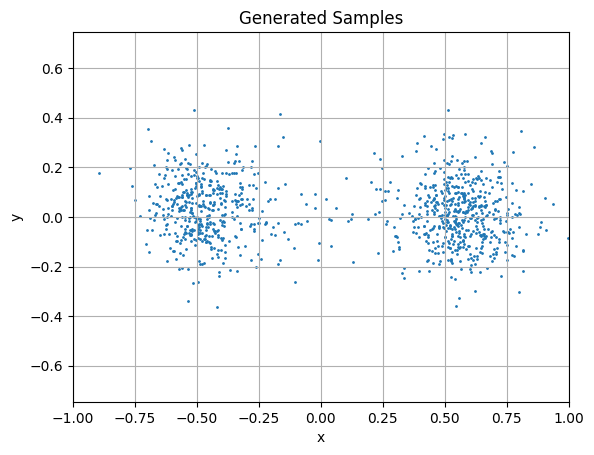

In [ ]:
samples = sample(
    model=simple_model,
    n_samples=1000,
    reverse_steps=100,
    schedule='linear',
    T=1
)
samples = samples.cpu().detach().numpy()

# plot samples
tmp_samples = samples.clip(-1, 1)
plt.scatter(tmp_samples[:, 0], tmp_samples[:, 1], s=1)
plt.axis('equal')
plt.xlabel('x')
plt.ylabel('y')
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.title('Generated Samples')
plt.grid(True)
plt.show()

## MNIST

### Non-conditional

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.Resize(32),
    transforms.CenterCrop(32),
    # transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load the MNIST dataset (only the first 36 images are needed for the grid)
mnist_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_loader = torch.utils.data.DataLoader(mnist_dataset, batch_size=64, shuffle=True)


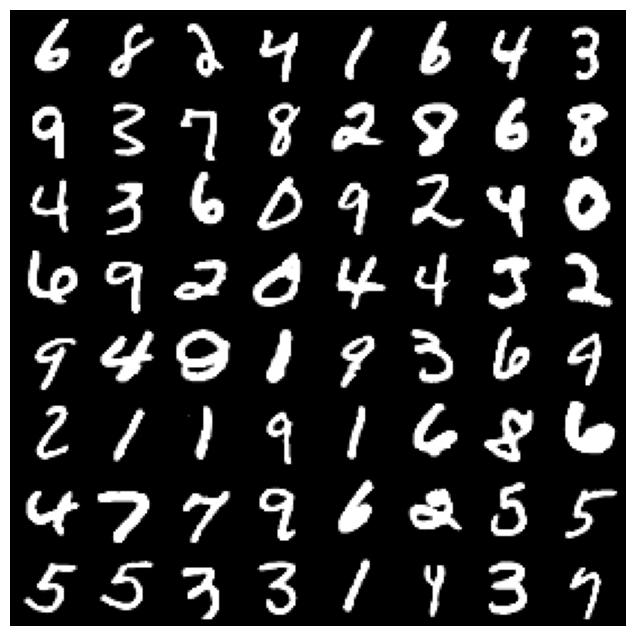

In [ ]:
# Get one batch of 64 images
images, _ = next(iter(mnist_loader))

# Create a 6x6 grid
grid = make_grid(images, nrow=8, padding=2)

# Plot the grid using matplotlib
plt.figure(figsize=(8, 8))
plt.imshow(grid.permute(1, 2, 0).squeeze(), cmap="gray")
plt.axis('off')
plt.show()

In [ ]:
import math

# def match_last_dims(data, shape):
#     """
#     Repeat a 1D tensor so that its last dimensions [1:] match `size[1:]`.
#     Useful for working with batched data.
#     """
#     assert data.ndim == 1, "Input must be 1D"
#     view_shape = [data.shape[0]] + [1] * (len(shape) - 1)
#     return data.view(*view_shape).expand(*shape)

def match_last_dims(data, shape):
    """
    Repeat a 1D tensor so that its last dimensions [1:] match `size[1:]`.
    Useful for working with batched data.
    """
    assert len(data.shape) == 1, "Data must be 1-dimensional (one value per batch)"
    for _ in range(len(shape) - 1):
        data = data.unsqueeze(-1)
    return data.repeat(1, *(shape[1:]))

def compute_beta_t(t_norm, T, schedule = 'linear'):
    # Compute β(t) depending on schedule.
    if schedule == 'linear':
        beta_min = 0.1
        beta_max = 20.0
        beta_t = beta_min + t_norm * (beta_max - beta_min)
    elif schedule == 'cosine':
        s = 0.008
        beta_t = (torch.pi / (T * (1 + s))) * torch.tan(((t_norm + s) / (1 + s)) * (torch.pi / 2))
    else:
        raise ValueError('Unknown schedule')
    return beta_t

def compute_alpha_bar(t_norm, schedule = 'linear'):
    if schedule == 'linear':
        beta_min = 0.1
        beta_max = 20.0
        integrated_beta = beta_min * t_norm + 0.5 * (beta_max - beta_min) * t_norm**2
        alpha_bar = torch.exp(-  integrated_beta)
    elif schedule == 'cosine':
        alpha_bar = 0.5 * (1 - torch.cos(t_norm * torch.pi))
        s = 0.008
        alpha_bar = torch.cos((t_norm + s) / (1 + s) * (torch.pi / 2))**2
    else:
        raise ValueError('Unknown schedule')
    return alpha_bar

# must return x_t and the added noise, we will need it later to compute the loss
def forward(x_start, t, T, schedule = 'linear'):
    t_norm = t / T
    alpha_bar = compute_alpha_bar(t_norm, schedule)
    # expand alpha_bar to the same shape as x_start, so that we can multiply them
    alpha_bar = match_last_dims(alpha_bar, x_start.shape)
    noise = torch.randn_like(x_start)
    x_t = torch.sqrt(alpha_bar)*x_start + torch.sqrt(1 - alpha_bar)*noise
    return x_t, noise

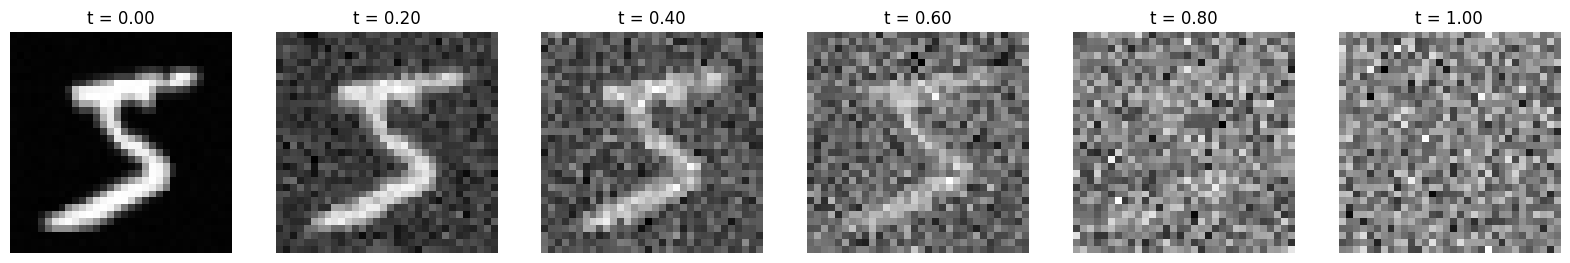

In [ ]:
x_start, _ = mnist_dataset[0]  # Get the first image
x_start = x_start.unsqueeze(0).to(device)  # Add batch dimension and move to device

# plot the empirical marginals p_t
def plot_ax_i(ax, x_t, title):
    ax.imshow(x_t[0].cpu().numpy(), cmap='gray')
    ax.axis('off')
    ax.set_title(title)

# Plot forward process at different timesteps
fig, axs = plt.subplots(1, 6, figsize=(20, 5))
T = 5
for i, t_norm in enumerate([0.0, 0.2, 0.4, 0.6, 0.8, 1]):
    t = t_norm * T * torch.ones(x_start.shape[0], device=device)
    x_t, _ = forward(x_start, t, T, schedule='cosine')
    plot_ax_i(axs[i], x_t[:, 0], f"t = {t_norm:.2f}")
plt.show()

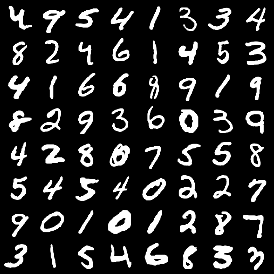

In [ ]:
# Get a batch of 32 images
x_start, _ = next(iter(mnist_loader))
x_start = x_start.to(device)

# Parameters
T = 30  # Total number of time steps
num_images = 30  # Number of images in the GIF
stepsize = int(T / num_images)  # Step size for time

# def plot_gif(ax, x_t):

result = []
for i, t in enumerate(range(0, T, stepsize)):
    t_norm = t / T
    t = t_norm * T * torch.ones(x_start.shape[0], device=device)
    x_t, _ = forward(x_start, t, T)
    grid = make_grid(x_t, nrow=8, padding=2).permute(1, 2, 0).cpu().numpy()  # Create a grid
    grid = (np.clip(grid, 0, 1) * 255).astype(np.uint8)  # Normalize and convert to uint8
    result.append(Image.fromarray(grid))  # Store as a frame

# Create GIF
buf = io.BytesIO()
result[0].save(buf, format="GIF", append_images=result[1:], save_all=True, duration=100, loop=0)
buf.seek(0)

# Save GIF locally
output_path = "diffusion_simulation_grid.gif"
result[0].save(output_path, format="GIF", append_images=result[1:], save_all=True, duration=100, loop=0)

# Display GIF
display(IPImage(buf.read(), width=512, height=512))

In [ ]:
import torch.nn.functional as F

def noise_loss(model, x_start, T):
    x_start = x_start.to(device)
    batch_size = x_start.shape[0]
    # Sample t uniformly from [0, T]
    t = torch.rand(batch_size, device=device) * T
    x_t, noise = forward(x_start, t, T)
    # The model takes x_t and t as input and predicts the noise. time t should be of shape (batch_size, 1)
    # we can pass normalized time to model as input
    t_norm = t / T
    predicted_noise = model(x_t, t_norm)
    loss = F.mse_loss(predicted_noise, noise)
    return loss

In [ ]:
from utils.unet import UNetModel

channels = 1
out_channels = 1

first_layer_embedding = False
embedding_dim = 3 # MD4 needs a value for masks, so set of values is {0, 1, 2}
output_dim = 1 # We only output a single probability value

model = UNetModel(
        in_channels=channels,
        model_channels=32,
        out_channels= out_channels,
        num_res_blocks=2,
        attention_resolutions= [2, 4],# tuple([2, 4]), # adds attention at image_size / 2 and /4
        dropout= 0.0,
        channel_mult= [1, 2, 2, 2], # divides image_size by two at each new item, except first one. [i] * model_channels
        dims = 2, # for images
        num_classes= None,#
        num_heads=4,
        num_heads_upsample=-1, # same as num_heads
        use_scale_shift_norm=True,
        first_layer_embedding=first_layer_embedding,
        embedding_dim= embedding_dim,
        output_dim = output_dim,
    )

model = model.to(device)

In [ ]:
# setting up the optimizer
import torch.optim as optim

optimizer = optim.AdamW(
    model.parameters(),
    lr=2e-3,
    betas=(0.9, 0.999))

In [ ]:
import os

def train(num_epochs, checkpoint_interval, dataloader, model, optimizer, checkpoint_dir, device, T = 1):
    print("Training on device:", device)

    # Set the model to training mode.
    model.train()

    epoch_losses = []
    for epoch in (range(1, num_epochs + 1)):
        # # Update learning rate via exponential decay
        # current_lr = learning_schedule(epoch, learning_rate=base_lr, exp_decay=exp_decay)
        # for param_group in optimizer.param_groups:
        #     param_group['lr'] = current_lr

        running_loss = 0.0

        for batch_idx, (data, _) in (enumerate(dataloader)):
            data = data.to(device)
            optimizer.zero_grad()

            # Compute the training loss.
            loss = noise_loss(model, x_start=data, T=T)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(dataloader)
        epoch_losses.append(avg_loss)
        print(f"Epoch [{epoch}] Average Loss: {avg_loss:.4f}")

        # # Save a checkpoint every checkpoint_interval epochs.
        # if epoch % checkpoint_interval == 0:
        #     os.makedirs(checkpoint_dir, exist_ok=True)
        #     checkpoint_path = os.path.join(checkpoint_dir, f"checkpoint_epoch_{epoch}.pth")
        #     torch.save({
        #         'epoch': epoch,
        #         'model_state_dict': model.state_dict(),
        #         'optimizer_state_dict': optimizer.state_dict(),
        #         'epoch_losses': epoch_losses,
        #         'mse_values': mse_values,
        #     }, checkpoint_path)
        #     print("Saved checkpoint to", checkpoint_path)

    print("Training finished.")

    # # Plotting the results
    # plt.figure(figsize=(12, 4))

    # # Loss plot
    # plt.subplot(1, 2, 1)
    # plt.plot(range(1, num_epochs + 1), epoch_losses, label="Loss")
    # plt.xlabel("Epoch")
    # plt.ylabel("Loss")
    # plt.title("Loss Function Over Epochs")
    # plt.legend()
    # plt.grid(True)

    # # MSE plot
    # plt.subplot(1, 2, 2)
    # plt.plot(range(1, num_epochs + 1), mse_values, label="MSE", color="orange")
    # plt.xlabel("Epoch")
    # plt.ylabel("Mean Squared Error")
    # plt.title("MSE Over Epochs")
    # plt.legend()
    # plt.grid(True)

    # plt.tight_layout()
    # plt.show()

In [ ]:
train(
    num_epochs=50,
    checkpoint_interval=50,
    dataloader=mnist_loader,
    model=model,
    optimizer=optimizer,
    checkpoint_dir='checkpoints',
    device = device
)

Training on device: cuda
Epoch [1] Average Loss: 0.0379
Epoch [2] Average Loss: 0.0255
Epoch [3] Average Loss: 0.0243
Epoch [4] Average Loss: 0.0228
Epoch [5] Average Loss: 0.0223
Epoch [6] Average Loss: 0.0220
Epoch [7] Average Loss: 0.0213
Epoch [8] Average Loss: 0.0215
Epoch [9] Average Loss: 0.0211
Epoch [10] Average Loss: 0.0210
Epoch [11] Average Loss: 0.0209
Epoch [12] Average Loss: 0.0208
Epoch [13] Average Loss: 0.0208
Epoch [14] Average Loss: 0.0208
Epoch [15] Average Loss: 0.0204
Epoch [16] Average Loss: 0.0204
Epoch [17] Average Loss: 0.0201
Epoch [18] Average Loss: 0.0204
Epoch [19] Average Loss: 0.0202
Epoch [20] Average Loss: 0.0201
Epoch [21] Average Loss: 0.0203
Epoch [22] Average Loss: 0.0201
Epoch [23] Average Loss: 0.0200
Epoch [24] Average Loss: 0.0201
Epoch [25] Average Loss: 0.0199
Epoch [26] Average Loss: 0.0201
Epoch [27] Average Loss: 0.0199
Epoch [28] Average Loss: 0.0198
Epoch [29] Average Loss: 0.0199
Epoch [30] Average Loss: 0.0200
Epoch [31] Average Loss:

In [ ]:
# Save model weights
torch.save(model.state_dict(), "trained/unconditioned_VP_mnist.pth")

In [ ]:
from tqdm import tqdm

def score_fn(model, x, t_norm):
    """
    Given the noise-predicting model, returns the score (i.e. ∇_x log p_t(x))
    at actual time t. Note that the model expects a normalized time (t/T).
    For VP: score = - (predicted noise) / sqrt(1 - ᾱ(t))
    """

    alpha_bar = compute_alpha_bar(t_norm).view(-1, *([1] * (x.dim() - 1)))
    epsilon = model(x, t_norm)
    score = - epsilon / torch.sqrt(1 - alpha_bar)
    return score

def sample(model, n_samples, reverse_steps, schedule = 'linear', T = 1):
    shape = (n_samples, 1, 32, 32)
    xt = torch.randn(shape, device=device)
    all_images = []
    model.eval()
    with torch.inference_mode():
        # Create a time discretization from T to 0
        t_seq = torch.linspace(T, 0, reverse_steps + 1, device=device)
        for i in tqdm(range(reverse_steps)):
            t_current = t_seq[i]
            t_next = t_seq[i + 1]
            dt = t_next - t_current  # dt is negative (reverse time)
            # Create a batch of current time values for the update.
            t_batch = torch.full((shape[0],), t_current, device=device)
            t_norm_batch = t_batch / T


            beta_t = compute_beta_t(t_norm_batch, T, schedule)
            beta_t = beta_t.view(-1, *([1] * (xt.dim() - 1)))


            f = -0.5 * beta_t * xt
            g = torch.sqrt(beta_t)


            # Get the score (using the noise-predicting network)
            score = score_fn(model, xt, t_batch)

            # Euler–Maruyama update:
            #   x = x + [f - g^2 * score] dt + g * sqrt(-dt) * z,   where z ~ N(0, I)
            z = torch.randn_like(xt)

            xt = xt + (f - (g**2) * score) * dt + g * torch.sqrt(-dt) * z

    return xt

We can finally sample new images.

100%|██████████| 500/500 [00:21<00:00, 23.40it/s]


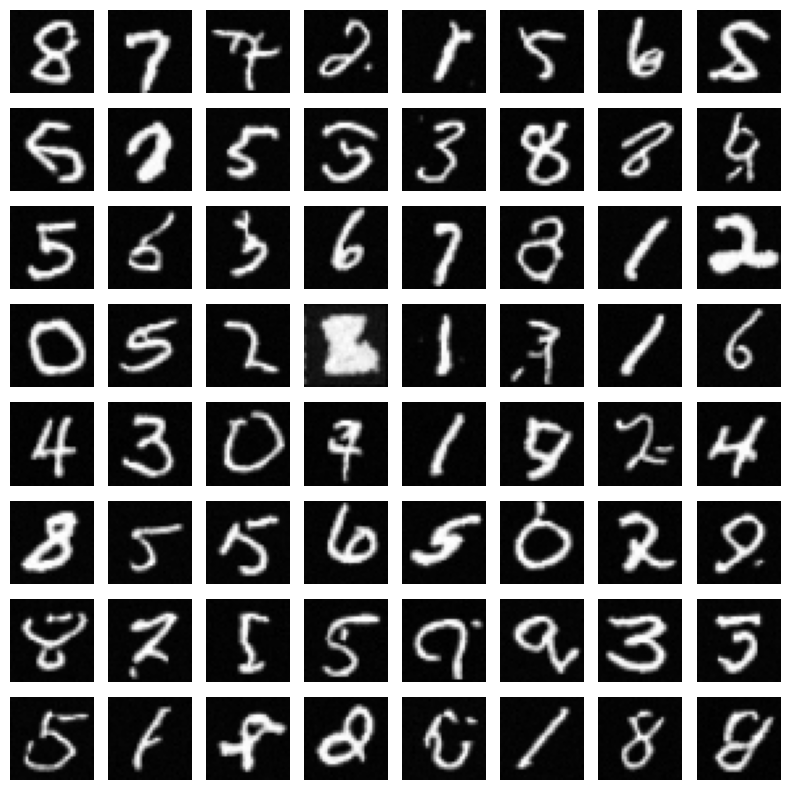

In [ ]:
samples = sample(
    model=model,
    n_samples=64,
    reverse_steps=500,
    schedule='linear',
    T=1
)
final_step_images = [s[-1].cpu().detach().numpy() for s in samples]

fig, axs = plt.subplots(8,8, figsize=(8,8))
for idx, ax in enumerate(axs.flat):
    ax.imshow(final_step_images[idx].squeeze(), cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.show()

100%|██████████| 500/500 [00:21<00:00, 23.33it/s]
<ipython-input-18-2f288a3cac3f>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  final_step_images = torch.stack([torch.tensor(s).cpu() for s in samples])


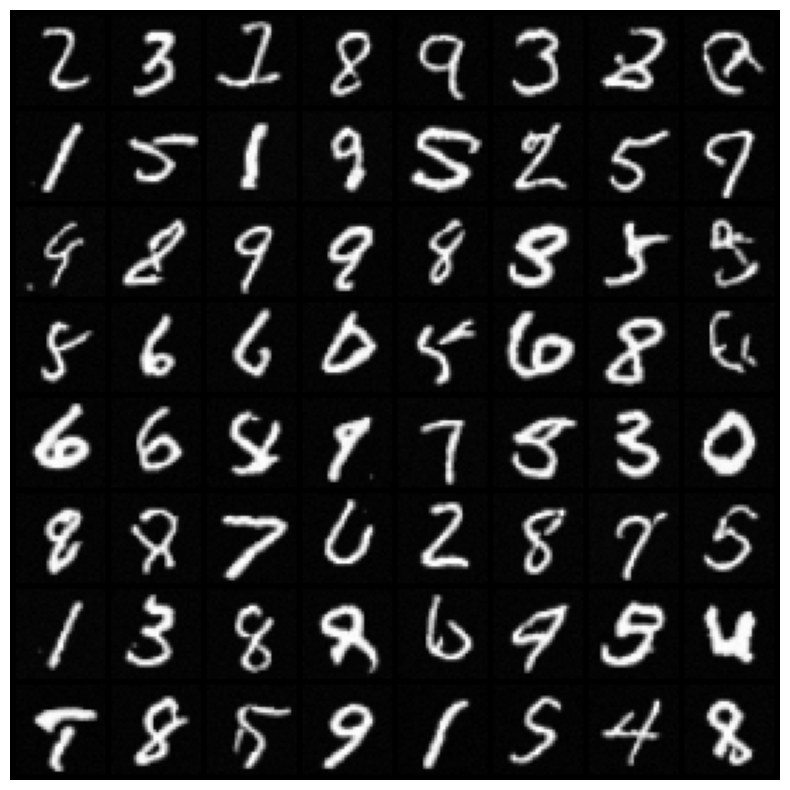

In [ ]:
from torchvision.utils import make_grid

samples = sample(
    model=model,
    n_samples=64,
    reverse_steps=500,
    schedule='linear',
    T=1
)

# Stack the final images into a tensor
final_step_images = torch.stack([torch.tensor(s).cpu() for s in samples])

# Create an 8x8 grid
grid = make_grid(final_step_images, nrow=8, normalize=True, scale_each=True)

# Plot the grid
plt.figure(figsize=(8, 8))
plt.imshow(grid.permute(1, 2, 0).squeeze(), cmap='gray')
plt.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
from tqdm import tqdm

def score_fn(model, x, t_norm):
    """
    Given the noise-predicting model, returns the score (i.e. ∇_x log p_t(x))
    at actual time t. Note that the model expects a normalized time (t/T).
    For VP: score = - (predicted noise) / sqrt(1 - ᾱ(t))
    """

    alpha_bar = compute_alpha_bar(t_norm).view(-1, *([1] * (x.dim() - 1)))
    epsilon = model(x, t_norm)
    score = - epsilon / torch.sqrt(1 - alpha_bar)
    return score

def sample(model, n_samples, reverse_steps, schedule = 'linear', T = 1):
    shape = (n_samples, 1, 32, 32)
    xt = torch.randn(shape, device=device)
    all_images = []
    model.eval()
    with torch.inference_mode():
        # Create a time discretization from T to 0
        t_seq = torch.linspace(T, 0, reverse_steps + 1, device=device)
        for i in tqdm(range(reverse_steps)):
            t_current = t_seq[i]
            t_next = t_seq[i + 1]
            dt = t_next - t_current  # dt is negative (reverse time)
            # Create a batch of current time values for the update.
            t_batch = torch.full((shape[0],), t_current, device=device)
            t_norm_batch = t_batch / T


            beta_t = compute_beta_t(t_norm_batch, T, schedule)
            beta_t = beta_t.view(-1, *([1] * (xt.dim() - 1)))


            f = -0.5 * beta_t * xt
            g = torch.sqrt(beta_t)


            # Get the score (using the noise-predicting network)
            score = score_fn(model, xt, t_batch)

            # Euler–Maruyama update:
            #   x = x + [f - g^2 * score] dt + g * sqrt(-dt) * z,   where z ~ N(0, I)
            z = torch.randn_like(xt)

            xt = xt + (f - (g**2) * score) * dt + g * torch.sqrt(-dt) * z
            all_images.append(xt)

    return all_images

In [ ]:
samples = sample(
    model=model,
    n_samples=4,
    reverse_steps=500,
    schedule='linear',
    T=1
)

# final_step_images = [s[-1].cpu().detach().numpy() for s in samples]

frames = []
for _, x_t in enumerate(samples):
    frame = make_grid(x_t, nrow=2, padding=2).permute(1, 2, 0).cpu().numpy()
    frame = (np.clip(frame, 0, 1) * 255).astype(np.uint8)
    frames.append(Image.fromarray(frame))

# Create GIF
buf = io.BytesIO()
frames[0].save(buf, format="GIF", append_images=frames[1:], save_all=True, duration=20, loop=0)
buf.seek(0)

# # Save GIF locally
output_path = "unconditioned.gif"
frames[0].save(output_path, format="GIF", append_images=frames[1:], save_all=True, duration=20, loop=0)

# Display GIF
display(IPImage(buf.read(), width=512, height=512))

Output hidden; open in https://colab.research.google.com to view.

### Conditional

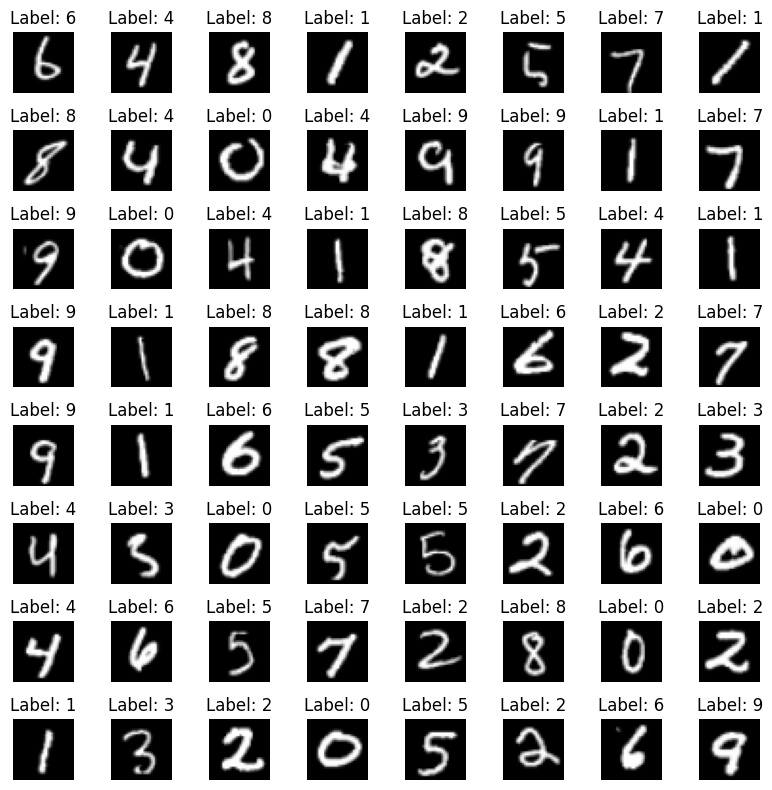

In [ ]:
x_start, label = next(iter(mnist_loader))

fig, axs = plt.subplots(8,8, figsize=(8,8))

for idx, ax in enumerate(axs.flat):
    ax.imshow(x_start[idx].squeeze(), cmap='gray')
    ax.set_title(f"Label: {label[idx]}")
    ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
import torch.nn.functional as F

def noise_loss(model, x_start, T, y):
    x_start = x_start.to(device)
    batch_size = x_start.shape[0]
    # Sample t uniformly from [0, T]
    t = torch.rand(batch_size, device=device) * T
    x_t, noise = forward(x_start, t, T)
    # The model takes x_t and t as input and predicts the noise. time t should be of shape (batch_size, 1)
    # we can pass normalized time to model as input
    t_norm = t / T

    predicted_noise = model(x_t, t_norm, y=y)
    loss = F.mse_loss(predicted_noise, noise)
    return loss

In [ ]:
from utils.unet import UNetModel

channels = 1
out_channels = 1

first_layer_embedding = False
embedding_dim = 3 # MD4 needs a value for masks, so set of values is {0, 1, 2}
output_dim = 1 # We only output a single probability value

model = UNetModel(
        in_channels=channels,
        model_channels=32,
        out_channels= out_channels,
        num_res_blocks=2,
        attention_resolutions= [2, 4],# tuple([2, 4]), # adds attention at image_size / 2 and /4
        dropout= 0.0,
        channel_mult= [1, 2, 2, 2], # divides image_size by two at each new item, except first one. [i] * model_channels
        dims = 2, # for images
        num_classes= 10,
        num_heads=4,
        num_heads_upsample=-1, # same as num_heads
        use_scale_shift_norm=True,
        first_layer_embedding=first_layer_embedding,
        embedding_dim= embedding_dim,
        output_dim = output_dim,
    )

model = model.to(device)

In [ ]:
# setting up the optimizer
import torch.optim as optim

optimizer = optim.AdamW(
    model.parameters(),
    lr=2e-3,
    betas=(0.9, 0.999))

In [ ]:
import os

def train(num_epochs, checkpoint_interval, dataloader, model, optimizer, checkpoint_dir, device, T = 1):
    print("Training on device:", device)

    # Set the model to training mode.
    model.train()

    epoch_losses = []
    for epoch in (range(1, num_epochs + 1)):
        # # Update learning rate via exponential decay
        # current_lr = learning_schedule(epoch, learning_rate=base_lr, exp_decay=exp_decay)
        # for param_group in optimizer.param_groups:
        #     param_group['lr'] = current_lr

        running_loss = 0.0

        for batch_idx, (data, y) in (enumerate(dataloader)):
            data = data.to(device)
            y = y.to(device)
            # print(data.shape, y.shape)
            # print(f"Label: {y}")
            # # 10% of the time, set y to null label = num_classes + 1
            # y[torch.rand_like(y) < 0.1] = 2 # whyy?
            optimizer.zero_grad()

            # Compute the training loss.
            loss = noise_loss(model, x_start=data, T=T, y=y.int())
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(dataloader)
        epoch_losses.append(avg_loss)
        print(f"Epoch [{epoch}] Average Loss: {avg_loss:.4f}")

        # # Save a checkpoint every checkpoint_interval epochs.
        # if epoch % checkpoint_interval == 0:
        #     os.makedirs(checkpoint_dir, exist_ok=True)
        #     checkpoint_path = os.path.join(checkpoint_dir, f"checkpoint_epoch_{epoch}.pth")
        #     torch.save({
        #         'epoch': epoch,
        #         'model_state_dict': model.state_dict(),
        #         'optimizer_state_dict': optimizer.state_dict(),
        #         'epoch_losses': epoch_losses,
        #         'mse_values': mse_values,
        #     }, checkpoint_path)
        #     print("Saved checkpoint to", checkpoint_path)

    print("Training finished.")

    # # Plotting the results
    # plt.figure(figsize=(12, 4))

    # # Loss plot
    # plt.subplot(1, 2, 1)
    # plt.plot(range(1, num_epochs + 1), epoch_losses, label="Loss")
    # plt.xlabel("Epoch")
    # plt.ylabel("Loss")
    # plt.title("Loss Function Over Epochs")
    # plt.legend()
    # plt.grid(True)

    # # MSE plot
    # plt.subplot(1, 2, 2)
    # plt.plot(range(1, num_epochs + 1), mse_values, label="MSE", color="orange")
    # plt.xlabel("Epoch")
    # plt.ylabel("Mean Squared Error")
    # plt.title("MSE Over Epochs")
    # plt.legend()
    # plt.grid(True)

    # plt.tight_layout()
    # plt.show()

In [ ]:
train(
    num_epochs=50,
    checkpoint_interval=50,
    dataloader=mnist_loader,
    model=model,
    optimizer=optimizer,
    checkpoint_dir='checkpoints',
    device = device
)

Training on device: cuda
Epoch [1] Average Loss: 0.0382
Epoch [2] Average Loss: 0.0248
Epoch [3] Average Loss: 0.0235
Epoch [4] Average Loss: 0.0224
Epoch [5] Average Loss: 0.0216
Epoch [6] Average Loss: 0.0212
Epoch [7] Average Loss: 0.0209
Epoch [8] Average Loss: 0.0209
Epoch [9] Average Loss: 0.0207
Epoch [10] Average Loss: 0.0204
Epoch [11] Average Loss: 0.0204
Epoch [12] Average Loss: 0.0204
Epoch [13] Average Loss: 0.0204
Epoch [14] Average Loss: 0.0200
Epoch [15] Average Loss: 0.0198
Epoch [16] Average Loss: 0.0199
Epoch [17] Average Loss: 0.0200
Epoch [18] Average Loss: 0.0197
Epoch [19] Average Loss: 0.0196
Epoch [20] Average Loss: 0.0197
Epoch [21] Average Loss: 0.0196
Epoch [22] Average Loss: 0.0197
Epoch [23] Average Loss: 0.0195
Epoch [24] Average Loss: 0.0195
Epoch [25] Average Loss: 0.0196
Epoch [26] Average Loss: 0.0196
Epoch [27] Average Loss: 0.0195
Epoch [28] Average Loss: 0.0193
Epoch [29] Average Loss: 0.0193
Epoch [30] Average Loss: 0.0195
Epoch [31] Average Loss:

In [ ]:
# Save model weights
torch.save(model.state_dict(), "trained/conditioned_VP_mnist.pth")

In [ ]:
from tqdm import tqdm

def score_fn(model, x, t_norm, y):
    """
    Given the noise-predicting model, returns the score (i.e. ∇_x log p_t(x))
    at actual time t. Note that the model expects a normalized time (t/T).
    For VP: score = - (predicted noise) / sqrt(1 - ᾱ(t))
    """

    alpha_bar = compute_alpha_bar(t_norm).view(-1, *([1] * (x.dim() - 1)))
    epsilon = model(x, t_norm, y.int())
    score = - epsilon / torch.sqrt(1 - alpha_bar)
    return score

def sample(model, n_samples, reverse_steps, class_label, deterministic = False, guidance_scale = 5.0, schedule = 'linear', T = 1):
    shape = (n_samples, 1, 32, 32)
    xt = torch.randn(shape, device=device)
    model.eval()
    with torch.inference_mode():
        # Create a time discretization from T to 0
        t_seq = torch.linspace(T, 0, reverse_steps + 1, device=device)
        for i in tqdm(range(reverse_steps)):
            t_current = t_seq[i]
            t_next = t_seq[i + 1]
            dt = t_next - t_current  # dt is negative (reverse time)
            # Create a batch of current time values for the update.
            t_batch = torch.full((shape[0],), t_current, device=device)
            t_norm_batch = t_batch / T


            beta_t = compute_beta_t(t_norm_batch, T, schedule)
            beta_t = beta_t.view(-1, *([1] * (xt.dim() - 1)))


            f = -0.5 * beta_t * xt
            g = torch.sqrt(beta_t)


            # Compute conditional score
            cond_class_label = torch.full((shape[0],), class_label, device=device)
            score_cond = score_fn(model, xt, t_batch, cond_class_label)

            # Compute the unconditional score (I have to fix this thing)
            # uncond_class_label = torch.full((shape[0],), 10, device=device)
            # score_uncond = score_fn(model, xt, t_batch, uncond_class_label)

            score = guidance_scale * score_cond # + (1 - guidance_scale) * score_uncond

            if deterministic:
                xt = xt + (f - (g**2) * score / 2) * dt
            else:
                # Euler–Maruyama update:
                #   x = x + [f - g^2 * score] dt + g * sqrt(-dt) * z,   where z ~ N(0, I)
                z = torch.randn_like(xt)
                xt = xt + (f - (g**2) * score) * dt + g * torch.sqrt(-dt) * z

    return xt

100%|██████████| 500/500 [00:21<00:00, 23.71it/s]
<ipython-input-17-d172e2c8790b>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  final_step_images = torch.stack([torch.tensor(s).cpu() for s in samples])


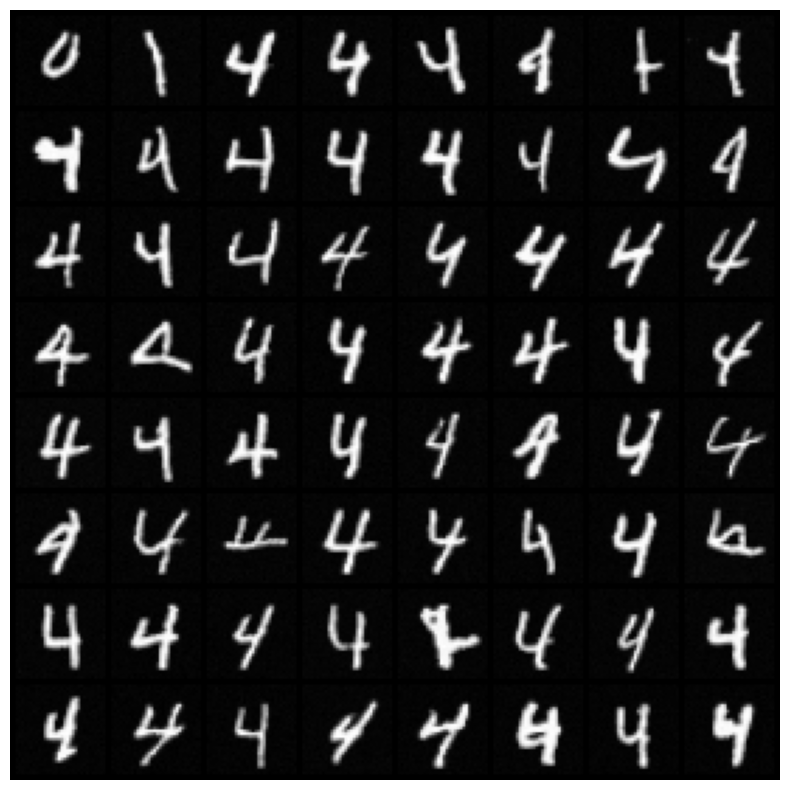

In [ ]:
from torchvision.utils import make_grid

class_label = 4
guidance_scale = 1.0
samples = sample(
    model=model,
    n_samples=64,
    reverse_steps=500,
    class_label=class_label,
    guidance_scale=guidance_scale,
    deterministic=False,
    schedule='linear',
    T=1
)

# Stack the final images into a tensor
final_step_images = torch.stack([torch.tensor(s).cpu() for s in samples])

# Create an 8x8 grid
grid = make_grid(final_step_images, nrow=8, normalize=True, scale_each=True)

# Plot the grid
plt.figure(figsize=(8,8))
plt.imshow(grid.permute(1, 2, 0).squeeze(), cmap='gray')
plt.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
from tqdm import tqdm

def score_fn(model, x, t_norm, y):
    """
    Given the noise-predicting model, returns the score (i.e. ∇_x log p_t(x))
    at actual time t. Note that the model expects a normalized time (t/T).
    For VP: score = - (predicted noise) / sqrt(1 - ᾱ(t))
    """

    alpha_bar = compute_alpha_bar(t_norm).view(-1, *([1] * (x.dim() - 1)))
    epsilon = model(x, t_norm, y.int())
    score = - epsilon / torch.sqrt(1 - alpha_bar)
    return score

def sample(model, n_samples, reverse_steps, class_label, deterministic = False, guidance_scale = 1.0, schedule = 'linear', T = 1):
    shape = (n_samples, 1, 32, 32)
    xt = torch.randn(shape, device=device)
    all_images = []
    model.eval()
    with torch.inference_mode():
        # Create a time discretization from T to 0
        t_seq = torch.linspace(T, 0, reverse_steps + 1, device=device)
        for i in tqdm(range(reverse_steps)):
            t_current = t_seq[i]
            t_next = t_seq[i + 1]
            dt = t_next - t_current  # dt is negative (reverse time)
            # Create a batch of current time values for the update.
            t_batch = torch.full((shape[0],), t_current, device=device)
            t_norm_batch = t_batch / T


            beta_t = compute_beta_t(t_norm_batch, T, schedule)
            beta_t = beta_t.view(-1, *([1] * (xt.dim() - 1)))


            f = -0.5 * beta_t * xt
            g = torch.sqrt(beta_t)


            # Compute conditional score
            cond_class_label = torch.full((shape[0],), class_label, device=device)
            score_cond = score_fn(model, xt, t_batch, cond_class_label)

            # Compute the unconditional score (I have to fix this thing)
            # uncond_class_label = torch.full((shape[0],), 10, device=device)
            # score_uncond = score_fn(model, xt, t_batch, uncond_class_label)

            score = guidance_scale * score_cond # + (1 - guidance_scale) * score_uncond

            if deterministic:
                xt = xt + (f - (g**2) * score / 2) * dt
            else:
                # Euler–Maruyama update:
                #   x = x + [f - g^2 * score] dt + g * sqrt(-dt) * z,   where z ~ N(0, I)
                z = torch.randn_like(xt)
                xt = xt + (f - (g**2) * score) * dt + g * torch.sqrt(-dt) * z

            all_images.append(xt)

    return all_images

In [ ]:
from torchvision.utils import make_grid

class_label = 4
guidance_scale = 1.0
samples = sample(
    model=model,
    n_samples=4,
    reverse_steps=500,
    class_label=class_label,
    guidance_scale=guidance_scale,
    deterministic=False,
    schedule='linear',
    T=1
)

frames = []
for _, x_t in enumerate(samples):
    frame = make_grid(x_t, nrow=2, padding=2).permute(1, 2, 0).cpu().numpy()
    frame = (np.clip(frame, 0, 1) * 255).astype(np.uint8)
    frames.append(Image.fromarray(frame))

# Create GIF
buf = io.BytesIO()
frames[0].save(buf, format="GIF", append_images=frames[1:], save_all=True, duration=20, loop=0)
buf.seek(0)

# # Save GIF locally
output_path = "conditioned.gif"
frames[0].save(output_path, format="GIF", append_images=frames[1:], save_all=True, duration=20, loop=0)

# Display GIF
display(IPImage(buf.read(), width=512, height=512))


Output hidden; open in https://colab.research.google.com to view.

## Generalization (working in progress)

### Unconditioned

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.Resize(32),
    transforms.CenterCrop(32),
    # transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load the MNIST dataset (only the first 36 images are needed for the grid)
mnist_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_loader = torch.utils.data.DataLoader(mnist_dataset, batch_size=64, shuffle=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 11.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 343kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 2.74MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.39MB/s]


In [2]:
import math


def match_last_dims(data, shape):
    """
    Repeat a 1D tensor so that its last dimensions [1:] match `size[1:]`.
    Useful for working with batched data.
    """
    assert len(data.shape) == 1, "Data must be 1-dimensional (one value per batch)"
    for _ in range(len(shape) - 1):
        data = data.unsqueeze(-1)
    return data.repeat(1, *(shape[1:]))

def compute_alpha_bar(t_norm, schedule = 'linear', process_type = 'VP'):
    """
    For VP processes, returns the cumulative product (or survival probability) at normalized time t_norm.
    For linear: ᾱ(t) = exp( - [β_min t + 0.5 (β_max - β_min)t^2] )
    For cosine: ᾱ(t) = cos( ((t + s)/(1+s))*(π/2) )^2
    """
    if process_type == 'VP':
        if schedule == 'linear':
            beta_min = 0.1
            beta_max = 20.0
            integrated_beta = beta_min * t_norm + 0.5 * (beta_max - beta_min) * t_norm**2
            alpha_bar = torch.exp(-  integrated_beta)
        elif schedule == 'cosine':
            alpha_bar = 0.5 * (1 - torch.cos(t_norm * torch.pi))
            s = 0.008
            alpha_bar = torch.cos((t_norm + s) / (1 + s) * (torch.pi / 2))**2
        return alpha_bar
    else:
        return None

def compute_sigma(t_norm, process_type = 'VE'):
    """
    For VE processes, returns the noise scale at normalized time t_norm.
    Using an exponential schedule: σ(t) = σ_min * (σ_max/σ_min)^t
    """
    if process_type == 'VE':
        sigma_min = 0.01
        sigma_max = 50.0

        sigma_t = sigma_min * (sigma_max/sigma_min)**t_norm

        return sigma_t
    else:
        return None

# must return x_t and the added noise, we will need it later to compute the loss
def forward(x_start, t, T, schedule = 'linear', process_type = 'VP'):
    t_norm = t / T
    noise = torch.randn_like(x_start)
    if process_type == 'VP':
        alpha_bar = compute_alpha_bar(t_norm, schedule, process_type)
        alpha_bar = match_last_dims(alpha_bar, x_start.shape)
        x_t = torch.sqrt(alpha_bar)*x_start + torch.sqrt(1 - alpha_bar)*noise
    elif process_type == 'VE':
        sigma = compute_sigma(t_norm, process_type)
        sigma = match_last_dims(sigma, x_start.shape)
        x_t = x_start + sigma * noise
    else:
        raise ValueError('Unknown schedule')
    return x_t, noise

In [3]:
import torch.nn.functional as F

def noise_loss(model, x_start, T, schedule = 'linear', process_type = 'VP'):
    x_start = x_start.to(device)
    batch_size = x_start.shape[0]
    # Sample t uniformly from [0, T]
    t = torch.rand(batch_size, device=device) * T
    x_t, noise = forward(x_start, t, T, schedule, process_type)
    # The model takes x_t and t as input and predicts the noise. time t should be of shape (batch_size, 1)
    # we can pass normalized time to model as input
    t_norm = t / T
    predicted_noise = model(x_t, t_norm)
    loss = F.mse_loss(predicted_noise, noise)
    return loss

In [9]:
from utils.unet import UNetModel

channels = 1
out_channels = 1

first_layer_embedding = False
embedding_dim = 3 # MD4 needs a value for masks, so set of values is {0, 1, 2}
output_dim = 1 # We only output a single probability value

model = UNetModel(
        in_channels=channels,
        model_channels=32,
        out_channels= out_channels,
        num_res_blocks=2,
        attention_resolutions= [2, 4],# tuple([2, 4]), # adds attention at image_size / 2 and /4
        dropout= 0.0,
        channel_mult= [1, 2, 2, 2], # divides image_size by two at each new item, except first one. [i] * model_channels
        dims = 2, # for images
        num_classes= None,#
        num_heads=4,
        num_heads_upsample=-1, # same as num_heads
        use_scale_shift_norm=True,
        first_layer_embedding=first_layer_embedding,
        embedding_dim= embedding_dim,
        output_dim = output_dim,
    )

model = model.to(device)

In [10]:
# setting up the optimizer
import torch.optim as optim

optimizer = optim.AdamW(
    model.parameters(),
    lr=2e-3,
    betas=(0.9, 0.999))

In [11]:
import os

def train(num_epochs, checkpoint_interval, dataloader, model, optimizer, checkpoint_dir, device, T = 1, schedule = 'linear', process_type = 'VP'):
    print("Training on device:", device)

    # Set the model to training mode.
    model.train()

    epoch_losses = []
    for epoch in (range(1, num_epochs + 1)):
        # # Update learning rate via exponential decay
        # current_lr = learning_schedule(epoch, learning_rate=base_lr, exp_decay=exp_decay)
        # for param_group in optimizer.param_groups:
        #     param_group['lr'] = current_lr

        running_loss = 0.0

        for batch_idx, (data, _) in (enumerate(dataloader)):
            data = data.to(device)
            optimizer.zero_grad()

            # Compute the training loss.
            loss = noise_loss(model, x_start=data, T=T, schedule=schedule, process_type=process_type)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(dataloader)
        epoch_losses.append(avg_loss)
        print(f"Epoch [{epoch}] Average Loss: {avg_loss:.4f}")

        # # Save a checkpoint every checkpoint_interval epochs.
        # if epoch % checkpoint_interval == 0:
        #     os.makedirs(checkpoint_dir, exist_ok=True)
        #     checkpoint_path = os.path.join(checkpoint_dir, f"checkpoint_epoch_{epoch}.pth")
        #     torch.save({
        #         'epoch': epoch,
        #         'model_state_dict': model.state_dict(),
        #         'optimizer_state_dict': optimizer.state_dict(),
        #         'epoch_losses': epoch_losses,
        #         'mse_values': mse_values,
        #     }, checkpoint_path)
        #     print("Saved checkpoint to", checkpoint_path)

    print("Training finished.")

    # # Plotting the results
    # plt.figure(figsize=(12, 4))

    # # Loss plot
    # plt.subplot(1, 2, 1)
    # plt.plot(range(1, num_epochs + 1), epoch_losses, label="Loss")
    # plt.xlabel("Epoch")
    # plt.ylabel("Loss")
    # plt.title("Loss Function Over Epochs")
    # plt.legend()
    # plt.grid(True)

    # # MSE plot
    # plt.subplot(1, 2, 2)
    # plt.plot(range(1, num_epochs + 1), mse_values, label="MSE", color="orange")
    # plt.xlabel("Epoch")
    # plt.ylabel("Mean Squared Error")
    # plt.title("MSE Over Epochs")
    # plt.legend()
    # plt.grid(True)

    # plt.tight_layout()
    # plt.show()

In [15]:
from tqdm import tqdm

def score_fn(model, x, t_norm, schedule = 'linear', process_type = 'VP'):
    """
    Given the noise-predicting model, returns the score (i.e. ∇_x log p_t(x))
    at actual time t. Note that the model expects a normalized time (t/T).
    For VP: score = - (predicted noise) / sqrt(1 - ᾱ(t))
    """
    if process_type == 'VP':
        alpha_bar = compute_alpha_bar(t_norm, schedule, process_type).view(-1, *([1] * (x.dim() - 1)))
        epsilon = model(x, t_norm)
        score = - epsilon / torch.sqrt(1 - alpha_bar)
    elif process_type == 'VE':
        sigma = compute_sigma(t_norm, process_type).view(-1, *([1] * (x.dim() - 1)))
        epsilon = model(x, t_norm)
        score = - epsilon / sigma
    return score

def sample(model, n_samples, reverse_steps, get_sample_history = False, deterministic = False, schedule = 'linear', process_type = 'VP', T = 1):
    """
    SDE sampling using the Euler–Maruyama method to solve the reverse-time SDE:
      dx = [f(x,t) - g(t)^2 * score(x,t)] dt + g(t) dẆ
    For VP:
      f(x,t) = -0.5 β(t)x  and  g(t) = sqrt(β(t))
      where β(t) is given either by a linear or cosine schedule.
    For VE:
      f(x,t) = 0  and  g(t) = σ(t)
    """
    shape = (n_samples, 1, 32, 32)
    history = []

    if process_type == 'VP':
        xt = torch.randn(shape, device=device)
    elif process_type == 'VE':
        t_norm = torch.tensor(1.0, device=device)
        sigma_T = compute_sigma(t_norm, process_type).view(*([1] * len(shape)))
        xt = torch.randn(shape, device=device) * sigma_T
    else:
        raise ValueError('Unknown schedule')


    model.eval()
    with torch.inference_mode():
        # Create a time discretization from T to 0
        t_seq = torch.linspace(T, 0, reverse_steps + 1, device=device)
        for i in tqdm(range(reverse_steps)):
            t_current = t_seq[i]
            t_next = t_seq[i + 1]
            dt = t_next - t_current  # dt is negative (reverse time)
            # Create a batch of current time values for the update.
            t_batch = torch.full((shape[0],), t_current, device=device)
            t_norm_batch = t_batch / T

            if process_type == 'VP':
                if schedule == 'linear':
                    beta_min = 0.1
                    beta_max = 20.0

                    beta_t = beta_min + t_norm_batch * (beta_max - beta_min)
                elif schedule == 'cosine':
                    s = 0.008
                    beta_t = (torch.pi / (T * (1 + s))) * torch.tan(((t_norm_batch + s) / (1 + s)) * (torch.pi / 2))


                beta_t = beta_t.view(-1, *([1] * (xt.dim() - 1)))
                f = -0.5 * beta_t * xt
                g = torch.sqrt(beta_t)
            elif process_type == 'VE':
                sigma_t = compute_sigma(t_norm_batch, process_type).view(-1, *([1] * (xt.dim() - 1)))
                f = torch.zeros_like(xt) # Maybe just 0.0?
                g = sigma_t


            # Get the score (using the noise-predicting network)
            score = score_fn(model, xt, t_batch, schedule, process_type)


            if deterministic:
                xt = xt + (f - (g**2) * score / 2) * dt
            else:
                # Euler–Maruyama update:
                #   x = x + [f - g^2 * score] dt + g * sqrt(-dt) * z,   where z ~ N(0, I)
                z = torch.randn_like(xt)

                xt = xt + (f - (g**2) * score) * dt + g * torch.sqrt(-dt) * z

            if get_sample_history:
                history.append(xt.clone())

    return xt if not get_sample_history else torch.stack(history) # Maybe just return history?

In [13]:
train(
    num_epochs=10,
    checkpoint_interval=50,
    dataloader=mnist_loader,
    model=model,
    optimizer=optimizer,
    checkpoint_dir='checkpoints',
    device = device,
    process_type = 'VP'
)

Training on device: cuda
Epoch [1] Average Loss: 0.0381
Epoch [2] Average Loss: 0.0254
Epoch [3] Average Loss: 0.0237
Epoch [4] Average Loss: 0.0229
Epoch [5] Average Loss: 0.0223
Epoch [6] Average Loss: 0.0217
Epoch [7] Average Loss: 0.0217
Epoch [8] Average Loss: 0.0215
Epoch [9] Average Loss: 0.0213
Epoch [10] Average Loss: 0.0210
Training finished.


100%|██████████| 100/100 [00:06<00:00, 15.17it/s]
<ipython-input-19-d11c98680f0b>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  final_step_images = torch.stack([torch.tensor(s).cpu() for s in samples])


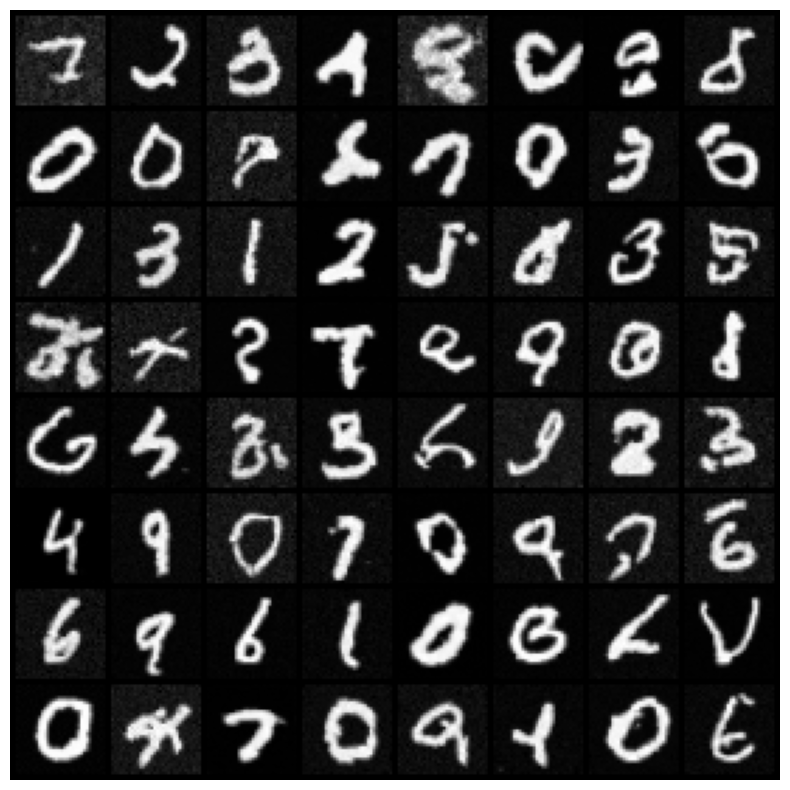

In [19]:
from torchvision.utils import make_grid

samples = sample(
    model=model,
    n_samples=64,
    reverse_steps=100,
    deterministic = True,
    # schedule='linear',
    process_type = 'VP',
    T=1
)

# Stack the final images into a tensor
final_step_images = torch.stack([torch.tensor(s).cpu() for s in samples])

# Create an 8x8 grid
grid = make_grid(final_step_images, nrow=8, normalize=True, scale_each=True)

# Plot the grid
plt.figure(figsize=(8, 8))
plt.imshow(grid.permute(1, 2, 0).squeeze(), cmap='gray')
plt.axis('off')
plt.tight_layout()
plt.show()

### Conditioned

In [20]:
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.Resize(32),
    transforms.CenterCrop(32),
    # transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load the MNIST dataset (only the first 36 images are needed for the grid)
mnist_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_loader = torch.utils.data.DataLoader(mnist_dataset, batch_size=64, shuffle=True)

In [21]:
import math


def match_last_dims(data, shape):
    """
    Repeat a 1D tensor so that its last dimensions [1:] match `size[1:]`.
    Useful for working with batched data.
    """
    assert len(data.shape) == 1, "Data must be 1-dimensional (one value per batch)"
    for _ in range(len(shape) - 1):
        data = data.unsqueeze(-1)
    return data.repeat(1, *(shape[1:]))

def compute_alpha_bar(t_norm, schedule = 'linear', process_type = 'VP'):
    """
    For VP processes, returns the cumulative product (or survival probability) at normalized time t_norm.
    For linear: ᾱ(t) = exp( - [β_min t + 0.5 (β_max - β_min)t^2] )
    For cosine: ᾱ(t) = cos( ((t + s)/(1+s))*(π/2) )^2
    """
    if process_type == 'VP':
        if schedule == 'linear':
            beta_min = 0.1
            beta_max = 20.0
            integrated_beta = beta_min * t_norm + 0.5 * (beta_max - beta_min) * t_norm**2
            alpha_bar = torch.exp(-  integrated_beta)
        elif schedule == 'cosine':
            alpha_bar = 0.5 * (1 - torch.cos(t_norm * torch.pi))
            s = 0.008
            alpha_bar = torch.cos((t_norm + s) / (1 + s) * (torch.pi / 2))**2
        return alpha_bar
    else:
        return None

def compute_sigma(t_norm, process_type = 'VE'):
    """
    For VE processes, returns the noise scale at normalized time t_norm.
    Using an exponential schedule: σ(t) = σ_min * (σ_max/σ_min)^t
    """
    if process_type == 'VE':
        sigma_min = 0.01
        sigma_max = 50.0

        sigma_t = sigma_min * (sigma_max/sigma_min)**t_norm

        return sigma_t
    else:
        return None

# must return x_t and the added noise, we will need it later to compute the loss
def forward(x_start, t, T, schedule = 'linear', process_type = 'VP'):
    t_norm = t / T
    noise = torch.randn_like(x_start)
    if process_type == 'VP':
        alpha_bar = compute_alpha_bar(t_norm, schedule, process_type)
        alpha_bar = match_last_dims(alpha_bar, x_start.shape)
        x_t = torch.sqrt(alpha_bar)*x_start + torch.sqrt(1 - alpha_bar)*noise
    elif process_type == 'VE':
        sigma = compute_sigma(t_norm, process_type)
        sigma = match_last_dims(sigma, x_start.shape)
        x_t = x_start + sigma * noise
    else:
        raise ValueError('Unknown schedule')
    return x_t, noise

In [ ]:
import torch.nn.functional as F

def noise_loss_conditioned(model, x_start, T, y, schedule = 'linear', process_type = 'VP'):
    x_start = x_start.to(device)
    batch_size = x_start.shape[0]
    # Sample t uniformly from [0, T]
    t = torch.rand(batch_size, device=device) * T
    x_t, noise = forward(x_start, t, T, schedule, process_type)
    # The model takes x_t and t as input and predicts the noise. time t should be of shape (batch_size, 1)
    # we can pass normalized time to model as input
    t_norm = t / T

    predicted_noise = model(x_t, t_norm, y=y)
    loss = F.mse_loss(predicted_noise, noise)
    return loss

def noise_loss_unconditioned(model, x_start, T, schedule = 'linear', process_type = 'VP'):
    x_start = x_start.to(device)
    batch_size = x_start.shape[0]
    # Sample t uniformly from [0, T]
    t = torch.rand(batch_size, device=device) * T
    x_t, noise = forward(x_start, t, T, schedule, process_type)
    # The model takes x_t and t as input and predicts the noise. time t should be of shape (batch_size, 1)
    # we can pass normalized time to model as input
    t_norm = t / T

    predicted_noise = model(x_t, t_norm)
    loss = F.mse_loss(predicted_noise, noise)
    return loss

In [22]:
def noise_loss(model, x_start, T, schedule = 'linear', process_type = 'VP', y = None):
    x_start = x_start.to(device)
    batch_size = x_start.shape[0]
    # Sample t uniformly from [0, T]
    t = torch.rand(batch_size, device=device) * T
    x_t, noise = forward(x_start, t, T, schedule, process_type)
    # The model takes x_t and t as input and predicts the noise. time t should be of shape (batch_size, 1)
    # we can pass normalized time to model as input
    t_norm = t / T

    if y is None:
        predicted_noise = model(x_t, t_norm)
    else:
        predicted_noise = model(x_t, t_norm, y=y)
    loss = F.mse_loss(predicted_noise, noise)
    return loss

In [ ]:
from utils.unet import UNetModel

channels = 1
out_channels = 1

first_layer_embedding = False
embedding_dim = 3 # MD4 needs a value for masks, so set of values is {0, 1, 2}
output_dim = 1 # We only output a single probability value

model = UNetModel(
        in_channels=channels,
        model_channels=32,
        out_channels= out_channels,
        num_res_blocks=2,
        attention_resolutions= [2, 4],# tuple([2, 4]), # adds attention at image_size / 2 and /4
        dropout= 0.0,
        channel_mult= [1, 2, 2, 2], # divides image_size by two at each new item, except first one. [i] * model_channels
        dims = 2, # for images
        num_classes= None,
        num_heads=4,
        num_heads_upsample=-1, # same as num_heads
        use_scale_shift_norm=True,
        first_layer_embedding=first_layer_embedding,
        embedding_dim= embedding_dim,
        output_dim = output_dim,
    )

model = model.to(device)

In [23]:
# setting up the optimizer
import torch.optim as optim

optimizer = optim.AdamW(
    model.parameters(),
    lr=2e-3,
    betas=(0.9, 0.999))

In [27]:
import os

def train(num_epochs, checkpoint_interval, dataloader, model, optimizer, checkpoint_dir, device, T = 1, schedule = 'linear', process_type = 'VP', conditioned = False):
    print("Training on device:", device)

    # Set the model to training mode.
    model.train()

    epoch_losses = []
    for epoch in (range(1, num_epochs + 1)):
        # # Update learning rate via exponential decay
        # current_lr = learning_schedule(epoch, learning_rate=base_lr, exp_decay=exp_decay)
        # for param_group in optimizer.param_groups:
        #     param_group['lr'] = current_lr

        running_loss = 0.0

        for batch_idx, (data, y) in (enumerate(dataloader)):
            data = data.to(device)
            optimizer.zero_grad()

            # Compute the training loss.
            if conditioned:
                y = y.to(device)
                y=y.int()
            else:
                y = None

            # Compute the loss and do the backprop
            loss = noise_loss(model, x_start=data, T=T, schedule=schedule, process_type=process_type, y=y)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(dataloader)
        epoch_losses.append(avg_loss)
        print(f"Epoch [{epoch}] Average Loss: {avg_loss:.4f}")

        # # Save a checkpoint every checkpoint_interval epochs.
        # if epoch % checkpoint_interval == 0:
        #     os.makedirs(checkpoint_dir, exist_ok=True)
        #     checkpoint_path = os.path.join(checkpoint_dir, f"checkpoint_epoch_{epoch}.pth")
        #     torch.save({
        #         'epoch': epoch,
        #         'model_state_dict': model.state_dict(),
        #         'optimizer_state_dict': optimizer.state_dict(),
        #         'epoch_losses': epoch_losses,
        #         'mse_values': mse_values,
        #     }, checkpoint_path)
        #     print("Saved checkpoint to", checkpoint_path)

    print("Training finished.")

    # # Plotting the results
    # plt.figure(figsize=(12, 4))

    # # Loss plot
    # plt.subplot(1, 2, 1)
    # plt.plot(range(1, num_epochs + 1), epoch_losses, label="Loss")
    # plt.xlabel("Epoch")
    # plt.ylabel("Loss")
    # plt.title("Loss Function Over Epochs")
    # plt.legend()
    # plt.grid(True)

    # # MSE plot
    # plt.subplot(1, 2, 2)
    # plt.plot(range(1, num_epochs + 1), mse_values, label="MSE", color="orange")
    # plt.xlabel("Epoch")
    # plt.ylabel("Mean Squared Error")
    # plt.title("MSE Over Epochs")
    # plt.legend()
    # plt.grid(True)

    # plt.tight_layout()
    # plt.show()

SyntaxError: invalid syntax (<ipython-input-27-2586e818fe27>, line 5)

In [28]:
train(
    num_epochs=15,
    checkpoint_interval=50,
    dataloader=mnist_loader,
    model=model,
    optimizer=optimizer,
    checkpoint_dir='checkpoints',
    device = device,
    conditioned = False
)

Training on device: cuda


AssertionError: must specify y if and only if the model is class-conditional

In [26]:
from tqdm import tqdm

def score_fn(model, x, t_norm, y):
    """
    Given the noise-predicting model, returns the score (i.e. ∇_x log p_t(x))
    at actual time t. Note that the model expects a normalized time (t/T).
    For VP: score = - (predicted noise) / sqrt(1 - ᾱ(t))
    """

    alpha_bar = compute_alpha_bar(t_norm).view(-1, *([1] * (x.dim() - 1)))
    if y is None:
        epsilon = model(x, t_norm)
    else:
        epsilon = model(x, t_norm, y.int())
    score = - epsilon / torch.sqrt(1 - alpha_bar)
    return score

def sample(model, n_samples, reverse_steps, class_label, get_sample_history = False, deterministic = False, schedule = 'linear', process_type = 'VP', T = 1):
    shape = (n_samples, 1, 32, 32)
    xt = torch.randn(shape, device=device)
    all_images = []
    model.eval()
    with torch.inference_mode():
        # Create a time discretization from T to 0
        t_seq = torch.linspace(T, 0, reverse_steps + 1, device=device)
        for i in tqdm(range(reverse_steps)):
            t_current = t_seq[i]
            t_next = t_seq[i + 1]
            dt = t_next - t_current  # dt is negative (reverse time)
            # Create a batch of current time values for the update.
            t_batch = torch.full((shape[0],), t_current, device=device)
            t_norm_batch = t_batch / T

            if process_type == 'VP':
                if schedule == 'linear':
                    beta_min = 0.1
                    beta_max = 20.0

                    beta_t = beta_min + t_norm_batch * (beta_max - beta_min)
                elif schedule == 'cosine':
                    s = 0.008
                    beta_t = (torch.pi / (T * (1 + s))) * torch.tan(((t_norm_batch + s) / (1 + s)) * (torch.pi / 2))


                beta_t = beta_t.view(-1, *([1] * (xt.dim() - 1)))
                f = -0.5 * beta_t * xt
                g = torch.sqrt(beta_t)
            elif process_type == 'VE':
                sigma_t = compute_sigma(t_norm_batch, process_type).view(-1, *([1] * (xt.dim() - 1)))
                f = torch.zeros_like(xt) # Maybe just 0.0?
                g = sigma_t


            beta_t = compute_beta_t(t_norm_batch, T, schedule)
            beta_t = beta_t.view(-1, *([1] * (xt.dim() - 1)))


            f = -0.5 * beta_t * xt
            g = torch.sqrt(beta_t)

            if class_label:
                cond_class_label = torch.full((shape[0],), class_label, device=device)
                score_cond = score_fn(model, xt, t_batch, cond_class_label)
                score = guidance_scale * score_cond
            else:
                score_uncond = score_fn(model, xt, t_batch, y=None)
                score = guidance_scale * score_uncond


            if deterministic:
                xt = xt + (f - (g**2) * score / 2) * dt
            else:
                # Euler–Maruyama update:
                #   x = x + [f - g^2 * score] dt + g * sqrt(-dt) * z,   where z ~ N(0, I)
                z = torch.randn_like(xt)
                xt = xt + (f - (g**2) * score) * dt + g * torch.sqrt(-dt) * z

            all_images.append(xt)

    return all_images

In [ ]:
from torchvision.utils import make_grid

class_label = None
guidance_scale = 1.0
samples = sample(
    model=model,
    n_samples=4,
    reverse_steps=500,
    class_label=class_label,
    guidance_scale=guidance_scale,
    deterministic=True,
    schedule='linear',
    process_type='VP',
    T=1
)

frames = []
for _, x_t in enumerate(samples):
    frame = make_grid(x_t, nrow=2, padding=2).permute(1, 2, 0).cpu().numpy()
    frame = (np.clip(frame, 0, 1) * 255).astype(np.uint8)
    frames.append(Image.fromarray(frame))

# Create GIF
buf = io.BytesIO()
frames[0].save(buf, format="GIF", append_images=frames[1:], save_all=True, duration=20, loop=0)
buf.seek(0)

# # Save GIF locally
output_path = "conditioned.gif"
frames[0].save(output_path, format="GIF", append_images=frames[1:], save_all=True, duration=20, loop=0)

# Display GIF
display(IPImage(buf.read(), width=512, height=512))


# Flow Matching

## Random dataset

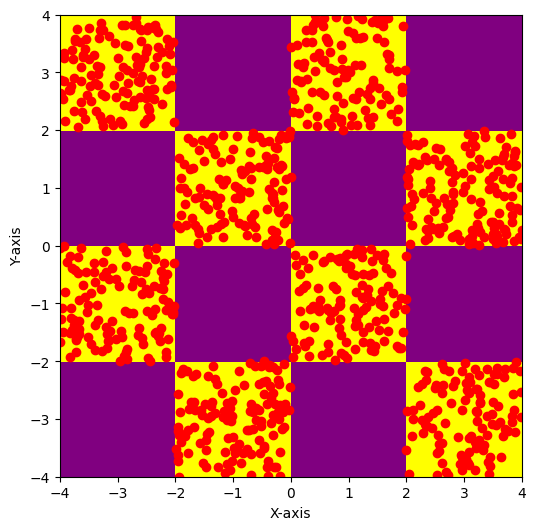

In [ ]:
import tqdm
import math
import torch
import numpy as np
from torch import nn
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Parameters
N = 1000  # Number of points to sample
x_min, x_max = -4, 4
y_min, y_max = -4, 4
resolution = 100  # Resolution of the grid

# Create the grid
x = np.linspace(x_min, x_max, resolution)
y = np.linspace(y_min, y_max, resolution)
X, Y = np.meshgrid(x, y)

# Checkerboard pattern
length = 4
checkerboard = np.indices((length, length)).sum(axis=0) % 2

# Sample points in regions where checkerboard pattern is 1
sampled_points = []
while len(sampled_points) < N:
    # Randomly sample a point within the x and y range
    x_sample = np.random.uniform(x_min, x_max)
    y_sample = np.random.uniform(y_min, y_max)

    # Determine the closest grid index
    i = int((x_sample - x_min) / (x_max - x_min) * length)
    j = int((y_sample - y_min) / (y_max - y_min) * length)

    # Check if the sampled point is in a region where checkerboard == 1
    if checkerboard[j, i] == 1:
        sampled_points.append((x_sample, y_sample))

# Convert to NumPy array for easier plotting
sampled_points = np.array(sampled_points)

# Plot the checkerboard pattern
plt.figure(figsize=(6, 6))
plt.imshow(checkerboard, extent=(x_min, x_max, y_min, y_max), origin="lower", cmap=ListedColormap(["purple", "yellow"]))

# Plot sampled points
plt.scatter(sampled_points[:, 0], sampled_points[:, 1], color="red", marker="o")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.show()

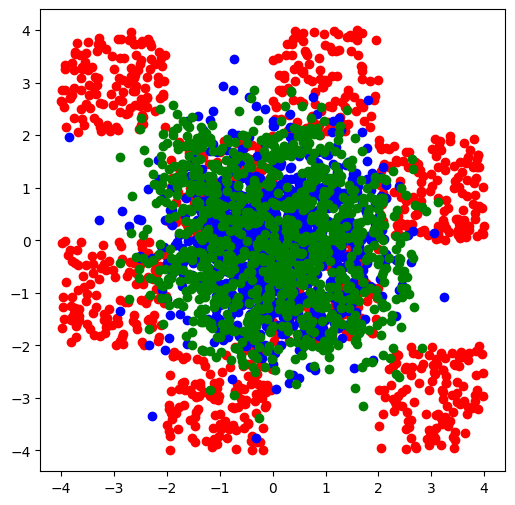

In [ ]:
t = 0.5
noise = np.random.randn(N, 2)
plt.figure(figsize=(6, 6))
plt.scatter(sampled_points[:, 0], sampled_points[:, 1], color="red", marker="o")
plt.scatter(noise[:, 0], noise[:, 1], color="blue", marker="o")
plt.scatter((1 - t) * noise[:, 0] + t * sampled_points[:, 0], (1 - t) * noise[:, 1] + t * sampled_points[:, 1], color="green", marker="o")
plt.show()

In [ ]:
class Block(nn.Module):
    def __init__(self, channels=512):
        super().__init__()
        self.ff = nn.Linear(channels, channels)
        self.act = nn.ReLU()

    def forward(self, x):
        return self.act(self.ff(x))

class MLP(nn.Module):
    def __init__(self, channels_data=2, layers=5, channels=512, channels_t=512):
        super().__init__()
        self.channels_t = channels_t
        self.in_projection = nn.Linear(channels_data, channels)
        self.t_projection = nn.Linear(channels_t, channels)
        self.blocks = nn.Sequential(*[
            Block(channels) for _ in range(layers)
        ])
        self.out_projection = nn.Linear(channels, channels_data)

    def gen_t_embedding(self, t, max_positions=10000):
        t = t * max_positions
        half_dim = self.channels_t // 2
        emb = math.log(max_positions) / (half_dim - 1)
        emb = torch.arange(half_dim, device=t.device).float().mul(-emb).exp()
        emb = t[:, None] * emb[None, :]
        emb = torch.cat([emb.sin(), emb.cos()], dim=1)
        if self.channels_t % 2 == 1:  # zero pad
            emb = nn.functional.pad(emb, (0, 1), mode='constant')
        return emb

    def forward(self, x, t):
        x = self.in_projection(x)
        t = self.gen_t_embedding(t)
        t = self.t_projection(t)
        x = x + t
        x = self.blocks(x)
        x = self.out_projection(x)
        return x

In [ ]:
model = MLP(layers=5, channels=512)
optim = torch.optim.AdamW(model.parameters(), lr=1e-4)

In [ ]:
data = torch.Tensor(sampled_points)
training_steps = 100_000
batch_size = 64
pbar = tqdm.tqdm(range(training_steps))
losses = []
for i in pbar:
    x1 = data[torch.randint(data.size(0), (batch_size,))]
    x0 = torch.randn_like(x1)
    target = x1 - x0
    t = torch.rand(x1.size(0))
    xt = (1 - t[:, None]) * x0 + t[:, None] * x1
    pred = model(xt, t)  # also add t here
    loss = ((target - pred)**2).mean()
    loss.backward()
    optim.step()
    optim.zero_grad()
    pbar.set_postfix(loss=loss.item())
    losses.append(loss.item())

100%|██████████| 100000/100000 [1:12:37<00:00, 22.95it/s, loss=3.34]


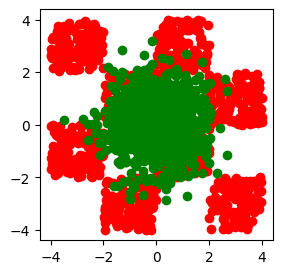

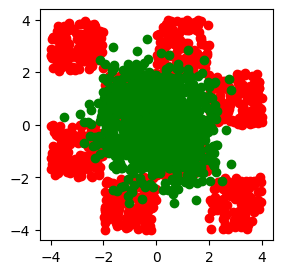

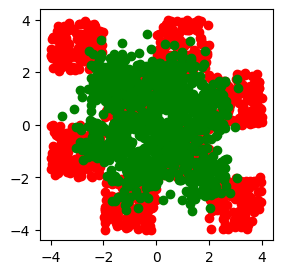

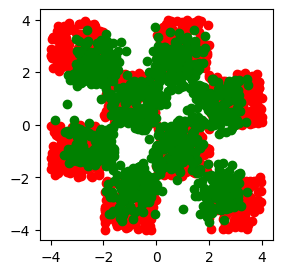

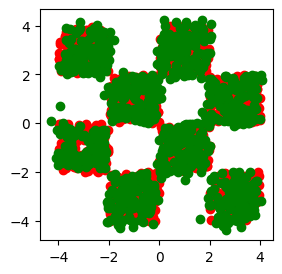

Done Sampling


In [ ]:
torch.manual_seed(42)
model.eval().requires_grad_(False)
xt = torch.randn(1000, 2)
steps = 1000
plot_every = 200
for i, t in enumerate(torch.linspace(0, 1, steps), start=1):
    pred = model(xt, t.expand(xt.size(0)))
    xt = xt + (1 / steps) * pred
    if i % plot_every == 0:
        plt.figure(figsize=(3,3))
        plt.scatter(sampled_points[:, 0], sampled_points[:, 1], color="red", marker="o")
        plt.scatter(xt[:, 0], xt[:, 1], color="green", marker="o")
        plt.show()
model.train().requires_grad_(True)
print("Done Sampling")

## MNIST

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.Resize(32),
    transforms.CenterCrop(32),
    # transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load the MNIST dataset (only the first 36 images are needed for the grid)
mnist_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_loader = torch.utils.data.DataLoader(mnist_dataset, batch_size=64, shuffle=True)

In [ ]:
def match_last_dims(data, shape):
    """
    Repeat a 1D tensor so that its last dimensions [1:] match `size[1:]`.
    Useful for working with batched data.
    """
    assert len(data.shape) == 1, "Data must be 1-dimensional (one value per batch)"
    for _ in range(len(shape) - 1):
        data = data.unsqueeze(-1)
    return data.repeat(1, *(shape[1:]))

In [ ]:
from utils.unet import UNetModel

channels = 1
out_channels = 1

first_layer_embedding = False
embedding_dim = 3 # MD4 needs a value for masks, so set of values is {0, 1, 2}
output_dim = 1 # We only output a single probability value

model = UNetModel(
        in_channels=channels,
        model_channels=32,
        out_channels= out_channels,
        num_res_blocks=2,
        attention_resolutions= [2, 4],# tuple([2, 4]), # adds attention at image_size / 2 and /4
        dropout= 0.0,
        channel_mult= [1, 2, 2, 2], # divides image_size by two at each new item, except first one. [i] * model_channels
        dims = 2, # for images
        num_classes=None,#
        num_heads=4,
        num_heads_upsample=-1, # same as num_heads
        use_scale_shift_norm=True,
        first_layer_embedding=first_layer_embedding,
        embedding_dim= embedding_dim,
        output_dim = output_dim,
    )

model = model.to(device)

In [ ]:
# setting up the optimizer
import torch.optim as optim

optimizer = optim.AdamW(
    model.parameters(),
    lr=2e-3,
    betas=(0.9, 0.999))

In [ ]:
import torch.nn.functional as F

def loss_fn(model, x_start, T, y):
    x_1 = x_start.to(device)
    batch_size = x_start.shape[0]
    x_0 = torch.rand_like(x_1)
    target = x_1 - x_0
    # Sample t uniformly from [0, T]
    t = torch.rand(batch_size, device=device) * T
    t_comp = match_last_dims(t, x_start.shape)
    x_t =(1-t_comp) * x_0 + t_comp * x_1

    t_norm = t/T
    if y is None:
        pred = model(x_t, t_norm)
    else:
        pred = model(x_t, t_norm, y=y)
    loss = F.mse_loss(pred, target)
    return loss

In [ ]:
import os

def train(num_epochs, checkpoint_interval, dataloader, model, optimizer, checkpoint_dir, device, T = 1, conditioned = False):
    print("Training on device:", device)

    # Set the model to training mode.
    model.train()

    epoch_losses = []
    for epoch in (range(1, num_epochs + 1)):
        # # Update learning rate via exponential decay
        # current_lr = learning_schedule(epoch, learning_rate=base_lr, exp_decay=exp_decay)
        # for param_group in optimizer.param_groups:
        #     param_group['lr'] = current_lr

        running_loss = 0.0

        for batch_idx, (data, y) in (enumerate(dataloader)):
            data = data.to(device)
            optimizer.zero_grad()

            if conditioned:
                y = y.to(device)
                y = y.int()
            else:
                y = None
            # Compute the training loss.
            loss = loss_fn(model, x_start=data, T=T, y=y)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(dataloader)
        epoch_losses.append(avg_loss)
        print(f"Epoch [{epoch}] Average Loss: {avg_loss:.4f}")

        # # Save a checkpoint every checkpoint_interval epochs.
        # if epoch % checkpoint_interval == 0:
        #     os.makedirs(checkpoint_dir, exist_ok=True)
        #     checkpoint_path = os.path.join(checkpoint_dir, f"checkpoint_epoch_{epoch}.pth")
        #     torch.save({
        #         'epoch': epoch,
        #         'model_state_dict': model.state_dict(),
        #         'optimizer_state_dict': optimizer.state_dict(),
        #         'epoch_losses': epoch_losses,
        #         'mse_values': mse_values,
        #     }, checkpoint_path)
        #     print("Saved checkpoint to", checkpoint_path)

    print("Training finished.")

    # # Plotting the results
    # plt.figure(figsize=(12, 4))

    # # Loss plot
    # plt.subplot(1, 2, 1)
    # plt.plot(range(1, num_epochs + 1), epoch_losses, label="Loss")
    # plt.xlabel("Epoch")
    # plt.ylabel("Loss")
    # plt.title("Loss Function Over Epochs")
    # plt.legend()
    # plt.grid(True)

    # # MSE plot
    # plt.subplot(1, 2, 2)
    # plt.plot(range(1, num_epochs + 1), mse_values, label="MSE", color="orange")
    # plt.xlabel("Epoch")
    # plt.ylabel("Mean Squared Error")
    # plt.title("MSE Over Epochs")
    # plt.legend()
    # plt.grid(True)

    # plt.tight_layout()
    # plt.show()

In [ ]:
train(
    num_epochs=10,
    checkpoint_interval=50,
    dataloader=mnist_loader,
    model=model,
    optimizer=optimizer,
    checkpoint_dir='checkpoints',
    device = device
)

Training on device: cuda
Epoch [1] Average Loss: 0.0481
Epoch [2] Average Loss: 0.0469
Epoch [3] Average Loss: 0.0451
Epoch [4] Average Loss: 0.0444
Epoch [5] Average Loss: 0.0442
Epoch [6] Average Loss: 0.0440
Epoch [7] Average Loss: 0.0442
Epoch [8] Average Loss: 0.0432
Epoch [9] Average Loss: 0.0424
Epoch [10] Average Loss: 0.0422
Training finished.


In [ ]:
# Save model weights
torch.save(model.state_dict(), "trained/flow_matching_unconditioned.pth")

In [ ]:
from tqdm import tqdm

def sample(model, n_samples, steps, class_label = None, T = 1):
    shape = (n_samples, 1, 32, 32)
    xt = torch.randn(shape, device=device)
    all_images = []
    model.eval()
    with torch.inference_mode():
        # Create a time discretization from T to 0
        t_seq = torch.linspace(0, T, steps + 1, device=device)
        for i in tqdm(range(steps)):
            t = t_seq[i]
            # Create a batch of current time values for the update.
            t_batch = torch.full((shape[0],), t, device=device)
            t_norm_batch = t_batch / T
            if class_label is None:
                xt = xt + (T / steps) * model(xt, t_norm_batch)
            else:
                cond_class_label = torch.full((shape[0],), class_label, device=device)
                xt = xt + (T / steps) * model(xt, t_norm_batch, cond_class_label)

            all_images.append(xt)

    return xt

  1%|          | 1/100 [00:00<00:14,  6.97it/s]

tensor(0., device='cuda:0')


  4%|▍         | 4/100 [00:00<00:10,  9.30it/s]

tensor(0.0100, device='cuda:0')
tensor(0.0200, device='cuda:0')
tensor(0.0300, device='cuda:0')
tensor(0.0400, device='cuda:0')


  9%|▉         | 9/100 [00:00<00:05, 15.99it/s]

tensor(0.0500, device='cuda:0')
tensor(0.0600, device='cuda:0')
tensor(0.0700, device='cuda:0')
tensor(0.0800, device='cuda:0')
tensor(0.0900, device='cuda:0')


 15%|█▌        | 15/100 [00:00<00:04, 20.46it/s]

tensor(0.1000, device='cuda:0')
tensor(0.1100, device='cuda:0')
tensor(0.1200, device='cuda:0')
tensor(0.1300, device='cuda:0')
tensor(0.1400, device='cuda:0')


 18%|█▊        | 18/100 [00:01<00:03, 21.46it/s]

tensor(0.1500, device='cuda:0')
tensor(0.1600, device='cuda:0')
tensor(0.1700, device='cuda:0')
tensor(0.1800, device='cuda:0')
tensor(0.1900, device='cuda:0')


 24%|██▍       | 24/100 [00:01<00:03, 22.86it/s]

tensor(0.2000, device='cuda:0')
tensor(0.2100, device='cuda:0')
tensor(0.2200, device='cuda:0')
tensor(0.2300, device='cuda:0')
tensor(0.2400, device='cuda:0')


 30%|███       | 30/100 [00:01<00:02, 23.67it/s]

tensor(0.2500, device='cuda:0')
tensor(0.2600, device='cuda:0')
tensor(0.2700, device='cuda:0')
tensor(0.2800, device='cuda:0')
tensor(0.2900, device='cuda:0')


 33%|███▎      | 33/100 [00:01<00:02, 23.83it/s]

tensor(0.3000, device='cuda:0')
tensor(0.3100, device='cuda:0')
tensor(0.3200, device='cuda:0')
tensor(0.3300, device='cuda:0')
tensor(0.3400, device='cuda:0')


 39%|███▉      | 39/100 [00:01<00:02, 24.04it/s]

tensor(0.3500, device='cuda:0')
tensor(0.3600, device='cuda:0')
tensor(0.3700, device='cuda:0')
tensor(0.3800, device='cuda:0')
tensor(0.3900, device='cuda:0')


 45%|████▌     | 45/100 [00:02<00:02, 23.69it/s]

tensor(0.4000, device='cuda:0')
tensor(0.4100, device='cuda:0')
tensor(0.4200, device='cuda:0')
tensor(0.4300, device='cuda:0')
tensor(0.4400, device='cuda:0')


 48%|████▊     | 48/100 [00:02<00:02, 23.44it/s]

tensor(0.4500, device='cuda:0')
tensor(0.4600, device='cuda:0')
tensor(0.4700, device='cuda:0')
tensor(0.4800, device='cuda:0')
tensor(0.4900, device='cuda:0')


 54%|█████▍    | 54/100 [00:02<00:01, 24.04it/s]

tensor(0.5000, device='cuda:0')
tensor(0.5100, device='cuda:0')
tensor(0.5200, device='cuda:0')
tensor(0.5300, device='cuda:0')
tensor(0.5400, device='cuda:0')


 60%|██████    | 60/100 [00:02<00:01, 24.12it/s]

tensor(0.5500, device='cuda:0')
tensor(0.5600, device='cuda:0')
tensor(0.5700, device='cuda:0')
tensor(0.5800, device='cuda:0')
tensor(0.5900, device='cuda:0')


 63%|██████▎   | 63/100 [00:02<00:01, 24.06it/s]

tensor(0.6000, device='cuda:0')
tensor(0.6100, device='cuda:0')
tensor(0.6200, device='cuda:0')
tensor(0.6300, device='cuda:0')
tensor(0.6400, device='cuda:0')


 69%|██████▉   | 69/100 [00:03<00:01, 24.05it/s]

tensor(0.6500, device='cuda:0')
tensor(0.6600, device='cuda:0')
tensor(0.6700, device='cuda:0')
tensor(0.6800, device='cuda:0')
tensor(0.6900, device='cuda:0')


 75%|███████▌  | 75/100 [00:03<00:01, 23.67it/s]

tensor(0.7000, device='cuda:0')
tensor(0.7100, device='cuda:0')
tensor(0.7200, device='cuda:0')
tensor(0.7300, device='cuda:0')
tensor(0.7400, device='cuda:0')


 78%|███████▊  | 78/100 [00:03<00:00, 22.72it/s]

tensor(0.7500, device='cuda:0')
tensor(0.7600, device='cuda:0')
tensor(0.7700, device='cuda:0')
tensor(0.7800, device='cuda:0')
tensor(0.7900, device='cuda:0')


 84%|████████▍ | 84/100 [00:03<00:00, 22.11it/s]

tensor(0.8000, device='cuda:0')
tensor(0.8100, device='cuda:0')
tensor(0.8200, device='cuda:0')
tensor(0.8300, device='cuda:0')
tensor(0.8400, device='cuda:0')


 87%|████████▋ | 87/100 [00:04<00:00, 21.85it/s]

tensor(0.8500, device='cuda:0')
tensor(0.8600, device='cuda:0')
tensor(0.8700, device='cuda:0')
tensor(0.8800, device='cuda:0')
tensor(0.8900, device='cuda:0')


 93%|█████████▎| 93/100 [00:04<00:00, 21.91it/s]

tensor(0.9000, device='cuda:0')
tensor(0.9100, device='cuda:0')
tensor(0.9200, device='cuda:0')
tensor(0.9300, device='cuda:0')
tensor(0.9400, device='cuda:0')


100%|██████████| 100/100 [00:04<00:00, 21.55it/s]

tensor(0.9500, device='cuda:0')
tensor(0.9600, device='cuda:0')
tensor(0.9700, device='cuda:0')
tensor(0.9800, device='cuda:0')
tensor(0.9900, device='cuda:0')



<ipython-input-126-3d50624856dd>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  final_step_images = torch.stack([torch.tensor(s).cpu() for s in samples])


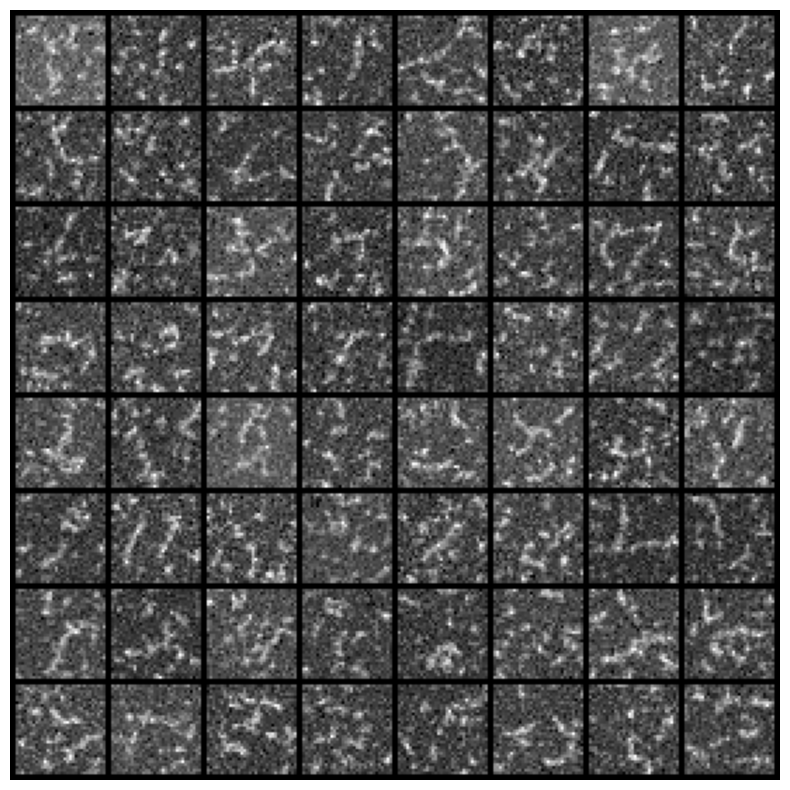

In [ ]:
from torchvision.utils import make_grid

samples = sample(
    model=model,
    n_samples=64,
    steps=100,
    class_label=None,
    T=1
)

# Stack the final images into a tensor
final_step_images = torch.stack([torch.tensor(s).cpu() for s in samples])

# Create an 8x8 grid
grid = make_grid(final_step_images, nrow=8, normalize=True, scale_each=True)

# Plot the grid
plt.figure(figsize=(8, 8))
plt.imshow(grid.permute(1, 2, 0).squeeze(), cmap='gray')
plt.axis('off')
plt.tight_layout()
plt.show()

# Bridge Matching

## MNIST

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.Resize(32),
    transforms.CenterCrop(32),
    # transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load the MNIST dataset (only the first 36 images are needed for the grid)
mnist_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_loader = torch.utils.data.DataLoader(mnist_dataset, batch_size=64, shuffle=True)

In [ ]:
def match_last_dims(data, shape):
    """
    Repeat a 1D tensor so that its last dimensions [1:] match `size[1:]`.
    Useful for working with batched data.
    """
    assert len(data.shape) == 1, "Data must be 1-dimensional (one value per batch)"
    for _ in range(len(shape) - 1):
        data = data.unsqueeze(-1)
    return data.repeat(1, *(shape[1:]))

In [ ]:
from utils.unet import UNetModel

channels = 1
out_channels = 1

first_layer_embedding = False
embedding_dim = 3 # MD4 needs a value for masks, so set of values is {0, 1, 2}
output_dim = 1 # We only output a single probability value

model = UNetModel(
        in_channels=channels,
        model_channels=32,
        out_channels= out_channels,
        num_res_blocks=2,
        attention_resolutions= [2, 4],# tuple([2, 4]), # adds attention at image_size / 2 and /4
        dropout= 0.0,
        channel_mult= [1, 2, 2, 2], # divides image_size by two at each new item, except first one. [i] * model_channels
        dims = 2, # for images
        num_classes=None,#
        num_heads=4,
        num_heads_upsample=-1, # same as num_heads
        use_scale_shift_norm=True,
        first_layer_embedding=first_layer_embedding,
        embedding_dim= embedding_dim,
        output_dim = output_dim,
    )

model = model.to(device)

In [ ]:
# setting up the optimizer
import torch.optim as optim

optimizer = optim.AdamW(
    model.parameters(),
    lr=2e-3,
    betas=(0.9, 0.999))

In [ ]:
import torch.nn.functional as F

def loss_fn(model, x_start, sigma, T, y):
    x_1 = x_start.to(device)
    batch_size = x_start.shape[0]
    x_0 = torch.rand_like(x_1)
    z = torch.rand_like(x_1)
    t = torch.rand(batch_size, device=x0.device) * T
    target = x_1 - x_0
    # Sample t uniformly from [0, T]
    t_comp = match_last_dims(t, x_start.shape)
    noise_term = noise_term = sigma * torch.sqrt(t_comp * (1 - t_comp)) * z
    x_t =(1-t_comp) * x_0 + t_comp * x_1 + noise_term

    target = x1 - x0 - noise_term

    t_norm = t/T
    if y is None:
        pred = model(x_t, t_norm)
    else:
        pred = model(x_t, t_norm, y=y)
    loss = F.mse_loss(pred, target)
    return loss

In [ ]:
import os

def train(num_epochs, checkpoint_interval, dataloader, model, optimizer, checkpoint_dir, device, T = 1, conditioned = False):
    print("Training on device:", device)

    # Set the model to training mode.
    model.train()

    epoch_losses = []
    for epoch in (range(1, num_epochs + 1)):
        # # Update learning rate via exponential decay
        # current_lr = learning_schedule(epoch, learning_rate=base_lr, exp_decay=exp_decay)
        # for param_group in optimizer.param_groups:
        #     param_group['lr'] = current_lr

        running_loss = 0.0

        for batch_idx, (data, y) in (enumerate(dataloader)):
            data = data.to(device)
            optimizer.zero_grad()

            if conditioned:
                y = y.to(device)
                y = y.int()
            else:
                y = None
            # Compute the training loss.
            loss = loss_fn(model, x_start=data, T=T, y=y)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(dataloader)
        epoch_losses.append(avg_loss)
        print(f"Epoch [{epoch}] Average Loss: {avg_loss:.4f}")

        # # Save a checkpoint every checkpoint_interval epochs.
        # if epoch % checkpoint_interval == 0:
        #     os.makedirs(checkpoint_dir, exist_ok=True)
        #     checkpoint_path = os.path.join(checkpoint_dir, f"checkpoint_epoch_{epoch}.pth")
        #     torch.save({
        #         'epoch': epoch,
        #         'model_state_dict': model.state_dict(),
        #         'optimizer_state_dict': optimizer.state_dict(),
        #         'epoch_losses': epoch_losses,
        #         'mse_values': mse_values,
        #     }, checkpoint_path)
        #     print("Saved checkpoint to", checkpoint_path)

    print("Training finished.")

    # # Plotting the results
    # plt.figure(figsize=(12, 4))

    # # Loss plot
    # plt.subplot(1, 2, 1)
    # plt.plot(range(1, num_epochs + 1), epoch_losses, label="Loss")
    # plt.xlabel("Epoch")
    # plt.ylabel("Loss")
    # plt.title("Loss Function Over Epochs")
    # plt.legend()
    # plt.grid(True)

    # # MSE plot
    # plt.subplot(1, 2, 2)
    # plt.plot(range(1, num_epochs + 1), mse_values, label="MSE", color="orange")
    # plt.xlabel("Epoch")
    # plt.ylabel("Mean Squared Error")
    # plt.title("MSE Over Epochs")
    # plt.legend()
    # plt.grid(True)

    # plt.tight_layout()
    # plt.show()

# El Quijote Simulations

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Load the 2D array
file_path = "df_z=0.npy"  # Replace with your actual file path
data = np.load(file_path)

# Print shape to verify
print("Data shape:", data.shape)  # Should output something like (256, 256)

Data shape: (256, 256)


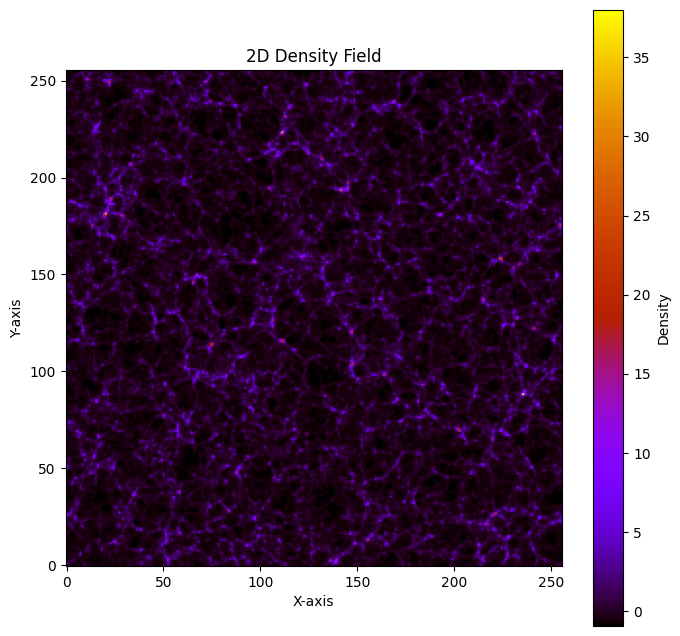

In [ ]:
# Create a figure
plt.figure(figsize=(8, 8))

# Display the data as an image
plt.imshow(data, cmap="gnuplot", origin="lower")

# Add a colorbar
plt.colorbar(label="Density")

# Labels and title
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.title("2D Density Field")

# Show the plot
plt.show()

In [ ]:
!pip install readgadget

ERROR: Could not find a version that satisfies the requirement readgadget (from versions: none)
ERROR: No matching distribution found for readgadget


In [ ]:
import numpy as np
import readgadget
import MAS_library as MASL

ModuleNotFoundError: No module named 'readgadget'